# 1.数据库连接

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from scipy import stats
import seaborn as sns
import pandas as pd
import random

In [1]:
import pymysql as mysql
import pandas as pd
try:
    db = mysql.connect(
      host = '192.168.30.177',
      user = 'zhouyuyan' ,
      passwd='Zhouyuyan2023', 
      port= 3306, 
      database='ousaite_data_2023_09_5min') # 数据库名称 
    print('连接成功！')
except:
    print('something wrong!')


def get_df_from_db(sql):
    cursor = db.cursor()#使用cursor()方法获取用于执行SQL语句的游标
    cursor.execute(sql)# 执行SQL语句
    """
    使用fetchall函数以元组形式返回所有查询结果并打印出来
    fetchone()返回第一行，fetchmany(n)返回前n行
    游标执行一次后则定位在当前操作行，下一次操作从当前操作行开始
    """
    data = cursor.fetchall()

    #下面为将获取的数据转化为dataframe格式
    columnDes = cursor.description #获取连接对象的描述信息
    columnNames = [columnDes[i][0] for i in range(len(columnDes))] #获取列名
    df = pd.DataFrame([list(i) for i in data],columns=columnNames) #得到的data为二维元组，逐行取出，转化为列表，再转化为df
    
    """
    使用完成之后需关闭游标和数据库连接，减少资源占用,cursor.close(),db.close()
    db.commit()若对数据库进行了修改，需进行提交之后再关闭
    """
    cursor.close()
    db.close()

    #print("cursor.description中的内容：",columnDes)
    return df

连接成功！


In [2]:
import time
start_time = time.time()
sql = "SELECT device_id,tempf,create_time FROM ost_202309_d1_g15_5min" # 对每日数据基本的一个预估 g1-g15
data = get_df_from_db(sql)  #  4731.4799172878265 s=6.7 分 太慢了！！！
end_time = time.time()
print("运行时间：", end_time - start_time, "s")
print(data) 

运行时间： 731.4799172878265 s
          device_id      tempf  create_time
0            143375     56.100   1693526400
1            145190     54.960   1693526400
2            145635     52.160   1693526400
3            148105     53.780   1693526400
4            147710     59.288   1693526400
...             ...        ...          ...
65325405     143903     62.780   1696117800
65325406     140508     59.000   1696118100
65325407     144127     62.060   1696103100
65325408     149542  32768.000   1696096800
65325409     147598     73.200   1696104900

[65325410 rows x 3 columns]


731.4799172878265

# 2.设备按device_id分类

In [4]:
from collections import Counter 
count = Counter(data["device_id"])
device_id = { k: v for k, v in count.items()}.keys()
#print(count)
#print(device_id)
print("设备总数是:",len(device_id))

设备总数是: 8091


# 3.数据预处理

In [12]:
# 删除无效值
data1 = data.drop(data[data.iloc[:, 1] == 32768].index)
count1 = Counter(data1["device_id"])
device_id = { k: v for k, v in count1.items()}.keys()
#print(count)
#print(device_id)
print("设备总数是:",len(device_id))

设备总数是: 7150


##  3.1 缺失值比例高的列删除

In [606]:
def drop_col(df, cutoff=0.7): # 如果这一列中有70%以上的缺失值，那么就从df中删除这一列
    n = len(df)
    cnt = df[(df==255)|(df==32768)].count()
    cnt = cnt/n
    df = df.loc[:, cnt[cnt <= cutoff].index] # 取无效值小于比例0.7的数
    return df

## 3.2 时间空缺记录

In [13]:
def time_empty(t):
    time_series = np.array(t)
    a = []
    dis, fre_sum = 0, 0
    for i in range(len(time_series)-1):
        if time_series[i+1]-time_series[i] != 300: 
            dis = (time_series[i+1]-time_series[i])/300-1  # 前提是设备按照5分种上传一次的标准
            tt = {dis:(time_series[i],time_series[i+1])}
            a.append(tt)
            fre_sum = dis+fre_sum
            #print(fre_sum)
        
       # print("time : %d, time_next : %d, Time interval : %d"%(time_series[i], time_series[i+1], dis))
    return a,fre_sum 

## 3.3 数据重新填充

缺失值分类：  
1.MCAR（missing completely at random)  
2.MAR  
3.NMAR  

In [608]:
fre = time_empty(dic[812]["create_time"])

KeyError: 812

# 4.导数

In [609]:
def derivative(t_od,y_od): 
    d1,d2 = [],[]
    # 把300的utc间隔缩小为5
    t_od = t_od/60 
# d1
    for i in range(len(y_od)-1):
        if (t_od.iloc[i+1]-t_od.iloc[i]) != 5: # 时间不连续
            d = None
            d1.append(d)
            i = i+1
        else:
            d = (y_od.iloc[i+1]-y_od.iloc[i])/(t_od.iloc[i+1]-t_od.iloc[i])
            d1.append(d)
# d2
    for i in range(1,len(d1)):
       # if (t_od.iloc[i+2]-t_od.iloc[i+1]) != 300: # 时间不连续\
        if((d1[i-1]==None)|(d1[i]==None)):
            d = None
            d2.append(d)
            i = i+1
        else:
            d = (d1[i]-d1[i-1])/((t_od.iloc[i+1]-t_od.iloc[i]))
            d2.append(d)   #d2
# 箱位图法
    d2 = [i for i in d2 if i != None]
    Q1 = np.percentile(d2,25, method='midpoint')
    Q3 = np.percentile(d2,75, method='midpoint')
    mean = np.percentile(d2,50, method='midpoint')
    IQR = Q3-Q1
    up = Q3+1.5*IQR
    down = Q1-1.5*IQR
    dmax = d2.max()
    dmin = d2.min()
    return up,down,mean,dmax,dmin
    #return d2


## 3.4 无效值行删除+无效值数据列记录

In [610]:
# 传入的设备已经是不包含设备id数据列的了
def outlier(df,de_id): # df 为dataframe类型
    # 写入空值数量  数据的数量
    #print("total Null:\n",df.isnull().sum(axis=0))
    start_time = df["create_time"].min()
    end_time = df["create_time"].max()
    time_point = (end_time-start_time)/300+1
    time_miss_interval, fre = time_empty(df["create_time"])
    data_amount = df.shape[0]
    df = df.dropna(how='any', axis=0) # 删除空值所在的行，默认空值比较少
    no_null = df.shape[0]
    df = drop_col(df) # 如果无效值比例过多，直接进行了列删除，数量不多的话，进行行删除
    invaid_1_col = [] # 255
    invaid_2_col = [] # 32768
    for i in range(0, df.shape[1]): 
        # 删除无效值 
        if (df.iloc[:,i]==255).any():
            invaid_1_col.append(df.columns[i])
        if (df.iloc[:,i]==32768).any():
            invaid_2_col.append(df.columns[i])
    for i in range(0, df.shape[1]):
        df = df.drop(df[df.iloc[:, i] == 255].index)  # 一旦有一个都要进行行删除
        df = df.drop(df[df.iloc[:, i] == 32768].index)
    no_Invalid = df.shape[0]
# 删除了无效值之后，数据的空缺更大了    
    #df = df.sample(frac=1)  # 把数据打乱
    features = df.columns.values
    time_miss_afdel, fre = time_empty(df["create_time"])
    up,down,mean = None,None,None
    try:
        up,down,mean =  derivative(df["create_time"],df["tempf"])
        e = "no error"
        z = [de_id,start_time,end_time,time_point,data_amount,no_null,no_Invalid,
             features,
             invaid_1_col,invaid_2_col,
             time_miss_interval,time_miss_afdel,up,down,mean,e]
        csv_writer.writerow(z)
    except Exception as e:
        z = [de_id,start_time,end_time,time_point,data_amount,no_null,no_Invalid,
             features,
             invaid_1_col,invaid_2_col,
             time_miss_interval,time_miss_afdel,up,down,mean,e]
        csv_writer.writerow(z)
        print("error:",e)

In [611]:
def outlier_copy(df): # df 为dataframe类型
    # 写入空值数量  数据的数量
    #print("total Null:\n",df.isnull().sum(axis=0))
    start_time = df["create_time"].min()
    end_time = df["create_time"].max()
    time_point = (end_time-start_time)/300+1
    time_miss_interval, fre = time_empty(df["create_time"])
    data_amount = df.shape[0]
    df = df.dropna(how='any', axis=0) # 删除空值所在的行，默认空值比较少
    no_null = df.shape[0]
    df = drop_col(df) # 如果无效值比例过多，直接进行了列删除，数量不多的话，进行行删除
    invaid_1_col = [] # 255
    invaid_2_col = [] # 32768
    for i in range(0, df.shape[1]): 
        # 删除无效值 
        if (df.iloc[:,i]==255).any():
            invaid_1_col.append(df.columns[i])
        if (df.iloc[:,i]==32768).any():
            invaid_2_col.append(df.columns[i])
    for i in range(0, df.shape[1]):
        df = df.drop(df[df.iloc[:, i] == 255].index)  # 一旦有一个都要进行行删除
        df = df.drop(df[df.iloc[:, i] == 32768].index)
    no_Invalid = df.shape[0]
    print(df["create_time"])
# 删除了无效值之后，数据的空缺更大了    
    #df = df.sample(frac=1)  # 把数据打乱
    features = df.columns.values
    time_miss_afdel, fre = time_empty(df["create_time"])
   # print(time_miss_afdel)
    up,down,mean = None,None,None
   # try:
    up,down,mean =  derivative(df["create_time"],df["tempf"])
   # print(up,down,mean)
        #e = "no error"
   # except Exception as e:
        #print("error:",e)
    return df

In [612]:
import csv
dic = {}  # 创一个字典
start = time.time()
with open('dd.csv','w',encoding='utf-8',newline='') as f:
        csv_writer = csv.writer(f)
        csv_writer.writerow(["device_id","start_time","end_time","time_point",
                           "data amount","no null","no Invalid",
                           "features","invaid_1_col","invaid_2_col",
                            "time_miss_interval","time_miss_afdel","up","down","mean","error"])
        j=0  # 记录一下运行的情况
        for i in device_id:
        # 将设备与其数据一一映射
        # 写入文件设备id
            t1 = time.time()
            #dic[i]=data.iloc[:,2:][data["device_id"]==i]  # 数据前两列分别是数据的id和uid，所以不取
            dic[i]=data.iloc[:,1:][data["device_id"]==i]  # 数据前两列分别是数据的id和uid，所以不取
            t2 = time.time()
            print ("第%d个设备,device_id = %d, 运行时间为: %fs"%(j+1,i,t2-t1))
            de_id = i
            j=j+1
            outlier(dic[i],de_id)
    # dic.keys()=divice_id,dic.values() 
        f.close()
end = time.time()
print("运行时间：", (end - start)/60, "min")

第1个设备,device_id = 143375, 运行时间为: 0.469096s
第2个设备,device_id = 145190, 运行时间为: 0.385356s
第3个设备,device_id = 145635, 运行时间为: 0.383986s
第4个设备,device_id = 148105, 运行时间为: 0.389967s
第5个设备,device_id = 147710, 运行时间为: 0.386155s
第6个设备,device_id = 144405, 运行时间为: 0.380662s
第7个设备,device_id = 145095, 运行时间为: 0.381715s
error: 'tempf'
第8个设备,device_id = 142200, 运行时间为: 0.419377s
第9个设备,device_id = 145245, 运行时间为: 0.378608s
第10个设备,device_id = 148265, 运行时间为: 0.409442s
error: 'tempf'
第11个设备,device_id = 142680, 运行时间为: 0.388183s
第12个设备,device_id = 146750, 运行时间为: 0.388131s
error: 'tempf'
第13个设备,device_id = 141310, 运行时间为: 0.388900s
第14个设备,device_id = 145975, 运行时间为: 0.389904s
第15个设备,device_id = 140200, 运行时间为: 0.370462s
第16个设备,device_id = 143215, 运行时间为: 0.395831s
第17个设备,device_id = 147230, 运行时间为: 0.379913s
第18个设备,device_id = 144470, 运行时间为: 0.388230s
第19个设备,device_id = 143685, 运行时间为: 0.378595s
第20个设备,device_id = 143925, 运行时间为: 0.401296s
第21个设备,device_id = 147940, 运行时间为: 0.389811s
第22个设备,device_id = 145200, 运行时间为: 0.3632

第179个设备,device_id = 143330, 运行时间为: 0.395909s
第180个设备,device_id = 148690, 运行时间为: 0.386759s
第181个设备,device_id = 143310, 运行时间为: 0.387908s
error: 'tempf'
第182个设备,device_id = 148515, 运行时间为: 0.375458s
第183个设备,device_id = 146940, 运行时间为: 0.385780s
error: 'tempf'
第184个设备,device_id = 140155, 运行时间为: 0.385878s
第185个设备,device_id = 144795, 运行时间为: 0.387992s
第186个设备,device_id = 141670, 运行时间为: 0.388507s
第187个设备,device_id = 146240, 运行时间为: 0.401336s
第188个设备,device_id = 143185, 运行时间为: 0.383893s
第189个设备,device_id = 142925, 运行时间为: 0.380300s
第190个设备,device_id = 143165, 运行时间为: 0.393879s
第191个设备,device_id = 145510, 运行时间为: 0.405143s
第192个设备,device_id = 144535, 运行时间为: 0.396019s
第193个设备,device_id = 142335, 运行时间为: 0.389070s
第194个设备,device_id = 146370, 运行时间为: 0.400136s
第195个设备,device_id = 140695, 运行时间为: 0.384491s
第196个设备,device_id = 144940, 运行时间为: 0.388000s
error: 'tempf'
第197个设备,device_id = 148480, 运行时间为: 0.391212s
第198个设备,device_id = 142135, 运行时间为: 0.399421s
第199个设备,device_id = 140015, 运行时间为: 0.393578s
第200个设备,de

第355个设备,device_id = 143365, 运行时间为: 0.383580s
第356个设备,device_id = 145120, 运行时间为: 0.397897s
第357个设备,device_id = 143665, 运行时间为: 0.399301s
第358个设备,device_id = 142025, 运行时间为: 0.384927s
第359个设备,device_id = 142495, 运行时间为: 0.382990s
第360个设备,device_id = 140370, 运行时间为: 0.385947s
error: 'tempf'
第361个设备,device_id = 143810, 运行时间为: 0.367282s
error: 'tempf'
第362个设备,device_id = 147170, 运行时间为: 0.417509s
第363个设备,device_id = 149515, 运行时间为: 0.394653s
第364个设备,device_id = 148370, 运行时间为: 0.385504s
第365个设备,device_id = 145350, 运行时间为: 0.381032s
第366个设备,device_id = 142350, 运行时间为: 0.378940s
第367个设备,device_id = 143420, 运行时间为: 0.388263s
第368个设备,device_id = 146465, 运行时间为: 0.390106s
第369个设备,device_id = 145010, 运行时间为: 0.384820s
第370个设备,device_id = 146290, 运行时间为: 0.370059s
第371个设备,device_id = 142930, 运行时间为: 0.401576s
第372个设备,device_id = 141105, 运行时间为: 0.385443s
第373个设备,device_id = 148470, 运行时间为: 0.392292s
第374个设备,device_id = 142790, 运行时间为: 0.389117s
第375个设备,device_id = 141565, 运行时间为: 0.378164s
第376个设备,device_id = 14490

第531个设备,device_id = 149590, 运行时间为: 0.396452s
第532个设备,device_id = 140525, 运行时间为: 0.403029s
error: 'tempf'
第533个设备,device_id = 141180, 运行时间为: 0.383508s
第534个设备,device_id = 141630, 运行时间为: 0.400100s
第535个设备,device_id = 149140, 运行时间为: 0.381171s
第536个设备,device_id = 147250, 运行时间为: 0.369434s
error: 'tempf'
第537个设备,device_id = 143255, 运行时间为: 0.411237s
第538个设备,device_id = 140550, 运行时间为: 0.392119s
第539个设备,device_id = 141300, 运行时间为: 0.383718s
error: 'tempf'
第540个设备,device_id = 148350, 运行时间为: 0.392622s
error: 'tempf'
第541个设备,device_id = 144495, 运行时间为: 0.384791s
第542个设备,device_id = 146365, 运行时间为: 0.394400s
error: 'tempf'
第543个设备,device_id = 149145, 运行时间为: 0.395169s
第544个设备,device_id = 144525, 运行时间为: 0.393020s
第545个设备,device_id = 149675, 运行时间为: 0.399328s
第546个设备,device_id = 147540, 运行时间为: 0.379158s
第547个设备,device_id = 140475, 运行时间为: 0.365980s
第548个设备,device_id = 144170, 运行时间为: 0.370521s
error: 'tempf'
第549个设备,device_id = 141475, 运行时间为: 0.412803s
第550个设备,device_id = 146135, 运行时间为: 0.377475s
第551个设备,de

第706个设备,device_id = 141930, 运行时间为: 0.393265s
第707个设备,device_id = 148725, 运行时间为: 0.403991s
error: 'tempf'
第708个设备,device_id = 142535, 运行时间为: 0.390674s
第709个设备,device_id = 147915, 运行时间为: 0.390239s
第710个设备,device_id = 147275, 运行时间为: 0.397461s
error: 'tempf'
第711个设备,device_id = 141890, 运行时间为: 0.378476s
第712个设备,device_id = 142760, 运行时间为: 0.391015s
error: 'tempf'
第713个设备,device_id = 149455, 运行时间为: 0.393248s
第714个设备,device_id = 146390, 运行时间为: 0.389537s
第715个设备,device_id = 146395, 运行时间为: 0.387964s
第716个设备,device_id = 143690, 运行时间为: 0.392853s
第717个设备,device_id = 144215, 运行时间为: 0.402402s
第718个设备,device_id = 143710, 运行时间为: 0.387570s
第719个设备,device_id = 140825, 运行时间为: 0.399177s
第720个设备,device_id = 143445, 运行时间为: 0.386294s
第721个设备,device_id = 148375, 运行时间为: 0.407684s
第722个设备,device_id = 141080, 运行时间为: 0.398452s
第723个设备,device_id = 149370, 运行时间为: 0.387139s
第724个设备,device_id = 140035, 运行时间为: 0.394874s
第725个设备,device_id = 142755, 运行时间为: 0.399851s
第726个设备,device_id = 140930, 运行时间为: 0.399105s
第727个设备,de

第882个设备,device_id = 142610, 运行时间为: 0.398202s
error: 'tempf'
第883个设备,device_id = 142570, 运行时间为: 0.404207s
第884个设备,device_id = 144625, 运行时间为: 0.393302s
第885个设备,device_id = 147765, 运行时间为: 0.394055s
第886个设备,device_id = 145860, 运行时间为: 0.385598s
error: 'tempf'
第887个设备,device_id = 149270, 运行时间为: 0.395704s
第888个设备,device_id = 143920, 运行时间为: 0.383024s
第889个设备,device_id = 145800, 运行时间为: 0.386415s
第890个设备,device_id = 147770, 运行时间为: 0.408715s
第891个设备,device_id = 146425, 运行时间为: 0.387677s
第892个设备,device_id = 145940, 运行时间为: 0.390223s
第893个设备,device_id = 142460, 运行时间为: 0.384903s
第894个设备,device_id = 147430, 运行时间为: 0.386050s
error: 'tempf'
第895个设备,device_id = 143050, 运行时间为: 0.383042s
第896个设备,device_id = 147535, 运行时间为: 0.384146s
第897个设备,device_id = 142110, 运行时间为: 0.394651s
第898个设备,device_id = 142250, 运行时间为: 0.392610s
第899个设备,device_id = 146665, 运行时间为: 0.379080s
第900个设备,device_id = 140830, 运行时间为: 0.405983s
error: 'tempf'
第901个设备,device_id = 144310, 运行时间为: 0.389349s
第902个设备,device_id = 149055, 运行时间为: 0.393

第1054个设备,device_id = 148170, 运行时间为: 0.395580s
第1055个设备,device_id = 143360, 运行时间为: 0.387714s
第1056个设备,device_id = 142305, 运行时间为: 0.385968s
第1057个设备,device_id = 142435, 运行时间为: 0.387873s
第1058个设备,device_id = 143305, 运行时间为: 0.389263s
error: 'tempf'
第1059个设备,device_id = 148890, 运行时间为: 0.386831s
第1060个设备,device_id = 149210, 运行时间为: 0.400288s
第1061个设备,device_id = 148540, 运行时间为: 0.393080s
第1062个设备,device_id = 142400, 运行时间为: 0.386739s
第1063个设备,device_id = 142770, 运行时间为: 0.395386s
第1064个设备,device_id = 143695, 运行时间为: 0.413187s
第1065个设备,device_id = 143910, 运行时间为: 0.389746s
第1066个设备,device_id = 146815, 运行时间为: 0.398290s
第1067个设备,device_id = 142915, 运行时间为: 0.406870s
第1068个设备,device_id = 140555, 运行时间为: 0.398246s
第1069个设备,device_id = 145495, 运行时间为: 0.396762s
第1070个设备,device_id = 148900, 运行时间为: 0.387192s
第1071个设备,device_id = 142740, 运行时间为: 0.407516s
第1072个设备,device_id = 144600, 运行时间为: 0.410793s
第1073个设备,device_id = 140790, 运行时间为: 0.393748s
第1074个设备,device_id = 142895, 运行时间为: 0.391054s
第1075个设备,device_id 

第1224个设备,device_id = 146220, 运行时间为: 0.394758s
第1225个设备,device_id = 141130, 运行时间为: 0.404413s
第1226个设备,device_id = 141695, 运行时间为: 0.430291s
error: 'tempf'
第1227个设备,device_id = 142735, 运行时间为: 0.379057s
error: 'tempf'
第1228个设备,device_id = 144920, 运行时间为: 0.382902s
第1229个设备,device_id = 142505, 运行时间为: 0.388209s
第1230个设备,device_id = 148235, 运行时间为: 0.406541s
第1231个设备,device_id = 141725, 运行时间为: 0.407929s
第1232个设备,device_id = 143965, 运行时间为: 0.414096s
第1233个设备,device_id = 140410, 运行时间为: 0.391898s
第1234个设备,device_id = 146525, 运行时间为: 0.387647s
第1235个设备,device_id = 140305, 运行时间为: 0.394298s
第1236个设备,device_id = 147720, 运行时间为: 0.396580s
第1237个设备,device_id = 142190, 运行时间为: 0.409090s
第1238个设备,device_id = 145755, 运行时间为: 0.394856s
error: 'tempf'
第1239个设备,device_id = 147700, 运行时间为: 0.428525s
第1240个设备,device_id = 142225, 运行时间为: 0.397655s
第1241个设备,device_id = 142180, 运行时间为: 0.390407s
第1242个设备,device_id = 142045, 运行时间为: 0.395180s
第1243个设备,device_id = 148620, 运行时间为: 0.382097s
第1244个设备,device_id = 140800, 运行时间为:

第1399个设备,device_id = 143335, 运行时间为: 0.408857s
第1400个设备,device_id = 144621, 运行时间为: 0.393018s
error: 'tempf'
第1401个设备,device_id = 145181, 运行时间为: 0.413737s
第1402个设备,device_id = 148695, 运行时间为: 0.398483s
第1403个设备,device_id = 147561, 运行时间为: 0.394902s
第1404个设备,device_id = 143630, 运行时间为: 0.391862s
第1405个设备,device_id = 140521, 运行时间为: 0.391164s
error: 'tempf'
第1406个设备,device_id = 141441, 运行时间为: 0.389704s
第1407个设备,device_id = 145930, 运行时间为: 0.406122s
第1408个设备,device_id = 146560, 运行时间为: 0.419308s
第1409个设备,device_id = 146710, 运行时间为: 0.401283s
第1410个设备,device_id = 143655, 运行时间为: 0.401633s
第1411个设备,device_id = 140651, 运行时间为: 0.390186s
error: 'tempf'
第1412个设备,device_id = 146416, 运行时间为: 0.385002s
第1413个设备,device_id = 146521, 运行时间为: 0.389949s
第1414个设备,device_id = 148461, 运行时间为: 0.392922s
第1415个设备,device_id = 148031, 运行时间为: 0.385580s
第1416个设备,device_id = 149291, 运行时间为: 0.417506s
第1417个设备,device_id = 142346, 运行时间为: 0.398253s
第1418个设备,device_id = 140396, 运行时间为: 0.391958s
第1419个设备,device_id = 146446, 运行时间为:

第1570个设备,device_id = 148331, 运行时间为: 0.317911s
第1571个设备,device_id = 145551, 运行时间为: 0.384890s
第1572个设备,device_id = 146541, 运行时间为: 0.388160s
第1573个设备,device_id = 144311, 运行时间为: 0.401450s
第1574个设备,device_id = 145831, 运行时间为: 0.396113s
第1575个设备,device_id = 144581, 运行时间为: 0.395622s
第1576个设备,device_id = 146826, 运行时间为: 0.392146s
第1577个设备,device_id = 145901, 运行时间为: 0.392091s
第1578个设备,device_id = 143851, 运行时间为: 0.392127s
第1579个设备,device_id = 142666, 运行时间为: 0.369168s
第1580个设备,device_id = 143846, 运行时间为: 0.402329s
第1581个设备,device_id = 147146, 运行时间为: 0.399236s
第1582个设备,device_id = 143656, 运行时间为: 0.388880s
第1583个设备,device_id = 140716, 运行时间为: 0.384571s
第1584个设备,device_id = 140811, 运行时间为: 0.392963s
第1585个设备,device_id = 142830, 运行时间为: 0.371738s
第1586个设备,device_id = 141076, 运行时间为: 0.386936s
第1587个设备,device_id = 143116, 运行时间为: 0.394107s
第1588个设备,device_id = 148416, 运行时间为: 0.398553s
第1589个设备,device_id = 141751, 运行时间为: 0.388506s
第1590个设备,device_id = 140346, 运行时间为: 0.384490s
第1591个设备,device_id = 147341, 运行时间为

第1743个设备,device_id = 149226, 运行时间为: 0.397106s
第1744个设备,device_id = 146941, 运行时间为: 0.404275s
第1745个设备,device_id = 149216, 运行时间为: 0.382278s
第1746个设备,device_id = 141191, 运行时间为: 0.394295s
第1747个设备,device_id = 148471, 运行时间为: 0.391354s
第1748个设备,device_id = 143716, 运行时间为: 0.404583s
第1749个设备,device_id = 145676, 运行时间为: 0.388892s
第1750个设备,device_id = 142036, 运行时间为: 0.390624s
第1751个设备,device_id = 140371, 运行时间为: 0.395451s
error: 'tempf'
第1752个设备,device_id = 148046, 运行时间为: 0.395856s
第1753个设备,device_id = 145156, 运行时间为: 0.386050s
error: 'tempf'
第1754个设备,device_id = 144161, 运行时间为: 0.400592s
error: 'tempf'
第1755个设备,device_id = 141101, 运行时间为: 0.376879s
第1756个设备,device_id = 145526, 运行时间为: 0.398968s
error: 'tempf'
第1757个设备,device_id = 143470, 运行时间为: 0.388618s
error: 'tempf'
第1758个设备,device_id = 142966, 运行时间为: 0.392948s
第1759个设备,device_id = 145371, 运行时间为: 0.393063s
第1760个设备,device_id = 146831, 运行时间为: 0.391478s
第1761个设备,device_id = 149566, 运行时间为: 0.375924s
第1762个设备,device_id = 141561, 运行时间为: 0.395095s
第1763

第1912个设备,device_id = 143251, 运行时间为: 0.394408s
第1913个设备,device_id = 147121, 运行时间为: 0.403456s
第1914个设备,device_id = 141371, 运行时间为: 0.399242s
error: 'tempf'
第1915个设备,device_id = 149501, 运行时间为: 0.392309s
error: 'tempf'
第1916个设备,device_id = 146165, 运行时间为: 0.384972s
第1917个设备,device_id = 147091, 运行时间为: 0.402102s
第1918个设备,device_id = 143671, 运行时间为: 0.397418s
第1919个设备,device_id = 142986, 运行时间为: 0.406312s
第1920个设备,device_id = 148146, 运行时间为: 0.390918s
第1921个设备,device_id = 148925, 运行时间为: 0.395131s
第1922个设备,device_id = 141096, 运行时间为: 0.404809s
第1923个设备,device_id = 142606, 运行时间为: 0.410919s
第1924个设备,device_id = 145666, 运行时间为: 0.400455s
第1925个设备,device_id = 143561, 运行时间为: 0.399388s
error: 'tempf'
第1926个设备,device_id = 144586, 运行时间为: 0.403650s
第1927个设备,device_id = 149276, 运行时间为: 0.398104s
第1928个设备,device_id = 142716, 运行时间为: 0.395878s
第1929个设备,device_id = 141556, 运行时间为: 0.392521s
error: 'tempf'
第1930个设备,device_id = 146356, 运行时间为: 0.381958s
第1931个设备,device_id = 140091, 运行时间为: 0.394567s
error: 'tempf'
第1932

第2082个设备,device_id = 140281, 运行时间为: 0.394160s
第2083个设备,device_id = 142906, 运行时间为: 0.400412s
第2084个设备,device_id = 149196, 运行时间为: 0.390482s
第2085个设备,device_id = 149396, 运行时间为: 0.397770s
第2086个设备,device_id = 148976, 运行时间为: 0.394540s
第2087个设备,device_id = 140831, 运行时间为: 0.391584s
第2088个设备,device_id = 148291, 运行时间为: 0.393197s
error: 'tempf'
第2089个设备,device_id = 143876, 运行时间为: 0.386420s
error: 'tempf'
第2090个设备,device_id = 141376, 运行时间为: 0.392444s
第2091个设备,device_id = 149356, 运行时间为: 0.389307s
第2092个设备,device_id = 140761, 运行时间为: 0.378158s
第2093个设备,device_id = 140260, 运行时间为: 0.386033s
第2094个设备,device_id = 142321, 运行时间为: 0.395143s
error: 'tempf'
第2095个设备,device_id = 145756, 运行时间为: 0.393207s
第2096个设备,device_id = 148791, 运行时间为: 0.390104s
error: 'tempf'
第2097个设备,device_id = 143856, 运行时间为: 0.384840s
第2098个设备,device_id = 144686, 运行时间为: 0.390676s
第2099个设备,device_id = 146556, 运行时间为: 0.386698s
第2100个设备,device_id = 148781, 运行时间为: 0.389367s
第2101个设备,device_id = 146206, 运行时间为: 0.387426s
第2102个设备,device_id =

第2253个设备,device_id = 147516, 运行时间为: 0.367922s
第2254个设备,device_id = 142941, 运行时间为: 0.390387s
第2255个设备,device_id = 140291, 运行时间为: 0.394472s
第2256个设备,device_id = 148431, 运行时间为: 0.393200s
第2257个设备,device_id = 140821, 运行时间为: 0.399605s
第2258个设备,device_id = 148401, 运行时间为: 0.386072s
error: 'tempf'
第2259个设备,device_id = 143066, 运行时间为: 0.407940s
第2260个设备,device_id = 143726, 运行时间为: 0.403648s
第2261个设备,device_id = 149331, 运行时间为: 0.394801s
第2262个设备,device_id = 140535, 运行时间为: 0.390867s
error: 'tempf'
第2263个设备,device_id = 140596, 运行时间为: 0.390385s
error: 'tempf'
第2264个设备,device_id = 142386, 运行时间为: 0.376281s
第2265个设备,device_id = 147791, 运行时间为: 0.408783s
第2266个设备,device_id = 144416, 运行时间为: 0.391642s
第2267个设备,device_id = 141941, 运行时间为: 0.384828s
第2268个设备,device_id = 143526, 运行时间为: 0.390153s
第2269个设备,device_id = 147966, 运行时间为: 0.386726s
第2270个设备,device_id = 145506, 运行时间为: 0.411303s
第2271个设备,device_id = 147036, 运行时间为: 0.390420s
第2272个设备,device_id = 141131, 运行时间为: 0.390261s
第2273个设备,device_id = 148996, 运行时间为:

第2425个设备,device_id = 140841, 运行时间为: 0.378618s
第2426个设备,device_id = 148946, 运行时间为: 0.387365s
第2427个设备,device_id = 140836, 运行时间为: 0.384902s
error: 'tempf'
第2428个设备,device_id = 145986, 运行时间为: 0.387878s
第2429个设备,device_id = 147601, 运行时间为: 0.385013s
第2430个设备,device_id = 140646, 运行时间为: 0.383319s
第2431个设备,device_id = 146261, 运行时间为: 0.409253s
第2432个设备,device_id = 147816, 运行时间为: 0.383865s
第2433个设备,device_id = 147566, 运行时间为: 0.390043s
第2434个设备,device_id = 141156, 运行时间为: 0.373171s
error: 'tempf'
第2435个设备,device_id = 142806, 运行时间为: 0.389047s
第2436个设备,device_id = 149591, 运行时间为: 0.383831s
第2437个设备,device_id = 140956, 运行时间为: 0.390416s
第2438个设备,device_id = 148281, 运行时间为: 0.403600s
第2439个设备,device_id = 148436, 运行时间为: 0.394813s
第2440个设备,device_id = 141910, 运行时间为: 0.384847s
第2441个设备,device_id = 143221, 运行时间为: 0.387289s
error: 'tempf'
第2442个设备,device_id = 147101, 运行时间为: 0.383913s
第2443个设备,device_id = 140261, 运行时间为: 0.388713s
第2444个设备,device_id = 140756, 运行时间为: 0.392517s
第2445个设备,device_id = 143456, 运行时间为:

第2595个设备,device_id = 149521, 运行时间为: 0.412460s
error: 'tempf'
第2596个设备,device_id = 143336, 运行时间为: 0.389036s
第2597个设备,device_id = 141806, 运行时间为: 0.403368s
第2598个设备,device_id = 141166, 运行时间为: 0.414254s
第2599个设备,device_id = 145301, 运行时间为: 0.394932s
第2600个设备,device_id = 148426, 运行时间为: 0.382459s
第2601个设备,device_id = 147271, 运行时间为: 0.402192s
第2602个设备,device_id = 149561, 运行时间为: 0.380565s
第2603个设备,device_id = 147996, 运行时间为: 0.393476s
第2604个设备,device_id = 145696, 运行时间为: 0.393295s
第2605个设备,device_id = 146771, 运行时间为: 0.401222s
第2606个设备,device_id = 140601, 运行时间为: 0.390897s
第2607个设备,device_id = 142381, 运行时间为: 0.391096s
第2608个设备,device_id = 141976, 运行时间为: 0.389086s
第2609个设备,device_id = 146431, 运行时间为: 0.410402s
第2610个设备,device_id = 141381, 运行时间为: 0.391171s
第2611个设备,device_id = 145991, 运行时间为: 0.389317s
第2612个设备,device_id = 144086, 运行时间为: 0.399597s
第2613个设备,device_id = 148351, 运行时间为: 0.404227s
第2614个设备,device_id = 143946, 运行时间为: 0.394495s
第2615个设备,device_id = 144126, 运行时间为: 0.384942s
error: 'tempf'
第261

第2765个设备,device_id = 142787, 运行时间为: 0.389849s
第2766个设备,device_id = 142231, 运行时间为: 0.377311s
第2767个设备,device_id = 146217, 运行时间为: 0.398146s
第2768个设备,device_id = 145222, 运行时间为: 0.385565s
第2769个设备,device_id = 142602, 运行时间为: 0.378632s
第2770个设备,device_id = 143417, 运行时间为: 0.394558s
第2771个设备,device_id = 143802, 运行时间为: 0.390357s
error: 'tempf'
第2772个设备,device_id = 144772, 运行时间为: 0.389802s
第2773个设备,device_id = 147845, 运行时间为: 0.389867s
第2774个设备,device_id = 145651, 运行时间为: 0.388240s
第2775个设备,device_id = 141252, 运行时间为: 0.397580s
第2776个设备,device_id = 141685, 运行时间为: 0.394288s
第2777个设备,device_id = 145661, 运行时间为: 0.383430s
第2778个设备,device_id = 144587, 运行时间为: 0.388205s
第2779个设备,device_id = 141316, 运行时间为: 0.396377s
第2780个设备,device_id = 149287, 运行时间为: 0.388096s
第2781个设备,device_id = 146111, 运行时间为: 0.397601s
第2782个设备,device_id = 147082, 运行时间为: 0.390810s
第2783个设备,device_id = 147432, 运行时间为: 0.407374s
第2784个设备,device_id = 141746, 运行时间为: 0.391155s
第2785个设备,device_id = 142255, 运行时间为: 0.381849s
第2786个设备,device_id 

第2937个设备,device_id = 144007, 运行时间为: 0.386276s
第2938个设备,device_id = 143152, 运行时间为: 0.381686s
第2939个设备,device_id = 147567, 运行时间为: 0.394000s
第2940个设备,device_id = 143062, 运行时间为: 0.391678s
第2941个设备,device_id = 147381, 运行时间为: 0.395545s
第2942个设备,device_id = 143482, 运行时间为: 0.399442s
error: 'tempf'
第2943个设备,device_id = 144867, 运行时间为: 0.380913s
第2944个设备,device_id = 144947, 运行时间为: 0.387963s
第2945个设备,device_id = 145092, 运行时间为: 0.403318s
第2946个设备,device_id = 145707, 运行时间为: 0.387312s
第2947个设备,device_id = 140057, 运行时间为: 0.381816s
第2948个设备,device_id = 143337, 运行时间为: 0.394681s
error: 'tempf'
第2949个设备,device_id = 140942, 运行时间为: 0.384831s
error: 'tempf'
第2950个设备,device_id = 147332, 运行时间为: 0.403704s
第2951个设备,device_id = 148147, 运行时间为: 0.388634s
第2952个设备,device_id = 145297, 运行时间为: 0.402206s
第2953个设备,device_id = 145961, 运行时间为: 0.380240s
第2954个设备,device_id = 145417, 运行时间为: 0.386779s
第2955个设备,device_id = 145752, 运行时间为: 0.413899s
第2956个设备,device_id = 142992, 运行时间为: 0.382257s
第2957个设备,device_id = 144997, 运行时间为:

第3107个设备,device_id = 141222, 运行时间为: 0.388390s
第3108个设备,device_id = 144081, 运行时间为: 0.408598s
第3109个设备,device_id = 142447, 运行时间为: 0.404267s
第3110个设备,device_id = 143162, 运行时间为: 0.379295s
第3111个设备,device_id = 143967, 运行时间为: 0.398087s
error: 'tempf'
第3112个设备,device_id = 144132, 运行时间为: 0.389355s
第3113个设备,device_id = 147137, 运行时间为: 0.396850s
error: 'tempf'
第3114个设备,device_id = 145382, 运行时间为: 0.400891s
第3115个设备,device_id = 146832, 运行时间为: 0.391711s
第3116个设备,device_id = 147447, 运行时间为: 0.400070s
第3117个设备,device_id = 146817, 运行时间为: 0.385116s
第3118个设备,device_id = 144982, 运行时间为: 0.408066s
第3119个设备,device_id = 148317, 运行时间为: 0.407072s
第3120个设备,device_id = 148547, 运行时间为: 0.391848s
第3121个设备,device_id = 149337, 运行时间为: 0.387704s
第3122个设备,device_id = 148542, 运行时间为: 0.391164s
第3123个设备,device_id = 141227, 运行时间为: 0.396028s
第3124个设备,device_id = 147832, 运行时间为: 0.406774s
第3125个设备,device_id = 148687, 运行时间为: 0.406527s
第3126个设备,device_id = 149552, 运行时间为: 0.374747s
第3127个设备,device_id = 143512, 运行时间为: 0.393881s
第312

第3279个设备,device_id = 144752, 运行时间为: 0.402952s
第3280个设备,device_id = 149627, 运行时间为: 0.375859s
error: 'tempf'
第3281个设备,device_id = 146432, 运行时间为: 0.386707s
第3282个设备,device_id = 140082, 运行时间为: 0.385810s
第3283个设备,device_id = 140402, 运行时间为: 0.407736s
第3284个设备,device_id = 143197, 运行时间为: 0.391252s
第3285个设备,device_id = 146137, 运行时间为: 0.389019s
第3286个设备,device_id = 147867, 运行时间为: 0.388229s
第3287个设备,device_id = 141306, 运行时间为: 0.388036s
第3288个设备,device_id = 147697, 运行时间为: 0.413048s
第3289个设备,device_id = 148607, 运行时间为: 0.400245s
第3290个设备,device_id = 141007, 运行时间为: 0.390511s
第3291个设备,device_id = 140842, 运行时间为: 0.383827s
第3292个设备,device_id = 141142, 运行时间为: 0.398121s
第3293个设备,device_id = 146177, 运行时间为: 0.398167s
第3294个设备,device_id = 142487, 运行时间为: 0.396460s
第3295个设备,device_id = 146437, 运行时间为: 0.389914s
第3296个设备,device_id = 149247, 运行时间为: 0.385128s
第3297个设备,device_id = 148267, 运行时间为: 0.395867s
第3298个设备,device_id = 149417, 运行时间为: 0.394197s
第3299个设备,device_id = 143182, 运行时间为: 0.385257s
第3300个设备,device_id 

第3452个设备,device_id = 147117, 运行时间为: 0.383706s
第3453个设备,device_id = 140822, 运行时间为: 0.387642s
error: 'tempf'
第3454个设备,device_id = 141265, 运行时间为: 0.385159s
error: 'tempf'
第3455个设备,device_id = 145302, 运行时间为: 0.384386s
第3456个设备,device_id = 143052, 运行时间为: 0.405459s
第3457个设备,device_id = 149657, 运行时间为: 0.377270s
第3458个设备,device_id = 141872, 运行时间为: 0.391568s
第3459个设备,device_id = 147737, 运行时间为: 0.387663s
第3460个设备,device_id = 147972, 运行时间为: 0.399827s
第3461个设备,device_id = 145057, 运行时间为: 0.394350s
第3462个设备,device_id = 140477, 运行时间为: 0.387845s
第3463个设备,device_id = 142022, 运行时间为: 0.386955s
第3464个设备,device_id = 144057, 运行时间为: 0.385682s
第3465个设备,device_id = 143422, 运行时间为: 0.396673s
第3466个设备,device_id = 146142, 运行时间为: 0.384288s
第3467个设备,device_id = 143357, 运行时间为: 0.390665s
第3468个设备,device_id = 143707, 运行时间为: 0.389662s
第3469个设备,device_id = 140687, 运行时间为: 0.391320s
error: 'tempf'
第3470个设备,device_id = 142687, 运行时间为: 0.391171s
第3471个设备,device_id = 141187, 运行时间为: 0.391890s
第3472个设备,device_id = 147587, 运行时间为:

第3623个设备,device_id = 142582, 运行时间为: 0.381616s
第3624个设备,device_id = 140007, 运行时间为: 0.372203s
第3625个设备,device_id = 144102, 运行时间为: 0.419735s
error: 'tempf'
第3626个设备,device_id = 140515, 运行时间为: 0.386203s
第3627个设备,device_id = 146757, 运行时间为: 0.386093s
第3628个设备,device_id = 140162, 运行时间为: 0.399438s
第3629个设备,device_id = 148537, 运行时间为: 0.388295s
第3630个设备,device_id = 143762, 运行时间为: 0.373318s
第3631个设备,device_id = 146037, 运行时间为: 0.385008s
第3632个设备,device_id = 142902, 运行时间为: 0.391224s
error: 'tempf'
第3633个设备,device_id = 140212, 运行时间为: 0.394313s
第3634个设备,device_id = 143911, 运行时间为: 0.386847s
第3635个设备,device_id = 142072, 运行时间为: 0.417321s
error: 'tempf'
第3636个设备,device_id = 141182, 运行时间为: 0.389208s
第3637个设备,device_id = 144447, 运行时间为: 0.411742s
第3638个设备,device_id = 146397, 运行时间为: 0.405276s
第3639个设备,device_id = 141297, 运行时间为: 0.395617s
第3640个设备,device_id = 143632, 运行时间为: 0.389770s
第3641个设备,device_id = 149012, 运行时间为: 0.342619s
第3642个设备,device_id = 146062, 运行时间为: 0.410055s
第3643个设备,device_id = 141157, 运行时间为:

第3795个设备,device_id = 140847, 运行时间为: 0.394305s
第3796个设备,device_id = 148741, 运行时间为: 0.409585s
error: 'tempf'
第3797个设备,device_id = 142912, 运行时间为: 0.388282s
第3798个设备,device_id = 144612, 运行时间为: 0.403979s
第3799个设备,device_id = 140182, 运行时间为: 0.400244s
第3800个设备,device_id = 149462, 运行时间为: 0.399684s
第3801个设备,device_id = 142142, 运行时间为: 0.401147s
第3802个设备,device_id = 142892, 运行时间为: 0.401112s
第3803个设备,device_id = 142327, 运行时间为: 0.412893s
第3804个设备,device_id = 144082, 运行时间为: 0.396674s
第3805个设备,device_id = 144262, 运行时间为: 0.390762s
第3806个设备,device_id = 146242, 运行时间为: 0.397110s
第3807个设备,device_id = 142717, 运行时间为: 0.394859s
第3808个设备,device_id = 142882, 运行时间为: 0.408647s
第3809个设备,device_id = 140257, 运行时间为: 0.403602s
第3810个设备,device_id = 143787, 运行时间为: 0.390263s
第3811个设备,device_id = 142207, 运行时间为: 0.393710s
第3812个设备,device_id = 144272, 运行时间为: 0.396022s
第3813个设备,device_id = 146952, 运行时间为: 0.402624s
第3814个设备,device_id = 145992, 运行时间为: 0.393577s
error: 'tempf'
第3815个设备,device_id = 140072, 运行时间为: 0.402177s
第381

第3964个设备,device_id = 140467, 运行时间为: 0.385859s
第3965个设备,device_id = 147702, 运行时间为: 0.365145s
第3966个设备,device_id = 143132, 运行时间为: 0.380123s
error: 'tempf'
第3967个设备,device_id = 143146, 运行时间为: 0.397800s
第3968个设备,device_id = 143832, 运行时间为: 0.389014s
第3969个设备,device_id = 141547, 运行时间为: 0.381565s
第3970个设备,device_id = 142127, 运行时间为: 0.389507s
第3971个设备,device_id = 147912, 运行时间为: 0.384686s
第3972个设备,device_id = 142002, 运行时间为: 0.385823s
第3973个设备,device_id = 141047, 运行时间为: 0.387086s
第3974个设备,device_id = 143732, 运行时间为: 0.382285s
第3975个设备,device_id = 146152, 运行时间为: 0.390206s
第3976个设备,device_id = 140322, 运行时间为: 0.379887s
第3977个设备,device_id = 141912, 运行时间为: 0.390165s
第3978个设备,device_id = 145522, 运行时间为: 0.373160s
error: 'tempf'
第3979个设备,device_id = 141752, 运行时间为: 0.408032s
第3980个设备,device_id = 143992, 运行时间为: 0.365690s
第3981个设备,device_id = 145997, 运行时间为: 0.385774s
第3982个设备,device_id = 148190, 运行时间为: 0.409645s
error: 'tempf'
第3983个设备,device_id = 141667, 运行时间为: 0.388510s
第3984个设备,device_id = 146172, 运行时间为:

第4137个设备,device_id = 147962, 运行时间为: 0.382407s
第4138个设备,device_id = 147642, 运行时间为: 0.402414s
第4139个设备,device_id = 145678, 运行时间为: 0.386252s
第4140个设备,device_id = 144753, 运行时间为: 0.398720s
第4141个设备,device_id = 140993, 运行时间为: 0.369764s
第4142个设备,device_id = 143358, 运行时间为: 0.400969s
error: 'tempf'
第4143个设备,device_id = 148512, 运行时间为: 0.385853s
第4144个设备,device_id = 148797, 运行时间为: 0.400100s
第4145个设备,device_id = 146067, 运行时间为: 0.401657s
第4146个设备,device_id = 148183, 运行时间为: 0.388263s
第4147个设备,device_id = 147283, 运行时间为: 0.395196s
error: 'tempf'
第4148个设备,device_id = 147723, 运行时间为: 0.386114s
第4149个设备,device_id = 149173, 运行时间为: 0.385446s
error: 'tempf'
第4150个设备,device_id = 142777, 运行时间为: 0.405094s
第4151个设备,device_id = 145037, 运行时间为: 0.389752s
第4152个设备,device_id = 144923, 运行时间为: 0.374810s
第4153个设备,device_id = 141513, 运行时间为: 0.392215s
error: 'tempf'
第4154个设备,device_id = 141082, 运行时间为: 0.392218s
第4155个设备,device_id = 145588, 运行时间为: 0.388992s
第4156个设备,device_id = 145513, 运行时间为: 0.383787s
第4157个设备,device_id =

第4310个设备,device_id = 143378, 运行时间为: 0.377924s
error: 'tempf'
第4311个设备,device_id = 146288, 运行时间为: 0.426197s
第4312个设备,device_id = 148648, 运行时间为: 0.396182s
第4313个设备,device_id = 141158, 运行时间为: 0.384040s
第4314个设备,device_id = 145598, 运行时间为: 0.391795s
error: 'tempf'
第4315个设备,device_id = 141747, 运行时间为: 0.390147s
第4316个设备,device_id = 144953, 运行时间为: 0.394078s
第4317个设备,device_id = 148173, 运行时间为: 0.396348s
第4318个设备,device_id = 146448, 运行时间为: 0.403557s
第4319个设备,device_id = 143383, 运行时间为: 0.378270s
第4320个设备,device_id = 142083, 运行时间为: 0.389209s
第4321个设备,device_id = 144958, 运行时间为: 0.392862s
第4322个设备,device_id = 146293, 运行时间为: 0.409727s
error: 'tempf'
第4323个设备,device_id = 149440, 运行时间为: 0.389295s
第4324个设备,device_id = 143163, 运行时间为: 0.383537s
第4325个设备,device_id = 149008, 运行时间为: 0.382232s
第4326个设备,device_id = 141557, 运行时间为: 0.386194s
第4327个设备,device_id = 140663, 运行时间为: 0.380612s
第4328个设备,device_id = 144913, 运行时间为: 0.377737s
第4329个设备,device_id = 147303, 运行时间为: 0.407795s
第4330个设备,device_id = 149278, 运行时间为:

第4482个设备,device_id = 141558, 运行时间为: 0.390120s
第4483个设备,device_id = 140492, 运行时间为: 0.381360s
第4484个设备,device_id = 140598, 运行时间为: 0.406029s
第4485个设备,device_id = 143538, 运行时间为: 0.398389s
第4486个设备,device_id = 141643, 运行时间为: 0.385209s
第4487个设备,device_id = 141878, 运行时间为: 0.398554s
第4488个设备,device_id = 148368, 运行时间为: 0.409641s
第4489个设备,device_id = 145393, 运行时间为: 0.392671s
第4490个设备,device_id = 148213, 运行时间为: 0.398135s
第4491个设备,device_id = 146863, 运行时间为: 0.383959s
第4492个设备,device_id = 146398, 运行时间为: 0.399945s
第4493个设备,device_id = 149398, 运行时间为: 0.390065s
第4494个设备,device_id = 149067, 运行时间为: 0.397239s
第4495个设备,device_id = 147033, 运行时间为: 0.385321s
第4496个设备,device_id = 147068, 运行时间为: 0.379755s
第4497个设备,device_id = 144208, 运行时间为: 0.422587s
第4498个设备,device_id = 145568, 运行时间为: 0.396674s
第4499个设备,device_id = 145013, 运行时间为: 0.388700s
第4500个设备,device_id = 141283, 运行时间为: 0.380258s
第4501个设备,device_id = 140113, 运行时间为: 0.393972s
error: 'tempf'
第4502个设备,device_id = 144763, 运行时间为: 0.389187s
第4503个设备,device_id 

第4654个设备,device_id = 143688, 运行时间为: 0.390999s
第4655个设备,device_id = 147511, 运行时间为: 0.379843s
第4656个设备,device_id = 141408, 运行时间为: 0.379658s
error: 'tempf'
第4657个设备,device_id = 141063, 运行时间为: 0.388160s
第4658个设备,device_id = 140653, 运行时间为: 0.390864s
第4659个设备,device_id = 149137, 运行时间为: 0.409378s
第4660个设备,device_id = 140613, 运行时间为: 0.398902s
第4661个设备,device_id = 144168, 运行时间为: 0.386706s
第4662个设备,device_id = 147963, 运行时间为: 0.384962s
第4663个设备,device_id = 148125, 运行时间为: 0.391098s
第4664个设备,device_id = 141923, 运行时间为: 0.408950s
error: 'tempf'
第4665个设备,device_id = 146766, 运行时间为: 0.384474s
第4666个设备,device_id = 147693, 运行时间为: 0.394680s
第4667个设备,device_id = 148753, 运行时间为: 0.396019s
第4668个设备,device_id = 141486, 运行时间为: 0.389143s
error: 'tempf'
第4669个设备,device_id = 143643, 运行时间为: 0.385711s
第4670个设备,device_id = 145333, 运行时间为: 0.373045s
第4671个设备,device_id = 148328, 运行时间为: 0.389273s
第4672个设备,device_id = 142938, 运行时间为: 0.386492s
第4673个设备,device_id = 143263, 运行时间为: 0.393307s
第4674个设备,device_id = 142053, 运行时间为:

第4824个设备,device_id = 145088, 运行时间为: 0.386207s
第4825个设备,device_id = 141428, 运行时间为: 0.374448s
第4826个设备,device_id = 145008, 运行时间为: 0.406686s
第4827个设备,device_id = 146868, 运行时间为: 0.389675s
第4828个设备,device_id = 143028, 运行时间为: 0.388240s
第4829个设备,device_id = 146463, 运行时间为: 0.398240s
error: 'tempf'
第4830个设备,device_id = 149108, 运行时间为: 0.387653s
第4831个设备,device_id = 145338, 运行时间为: 0.380400s
第4832个设备,device_id = 143988, 运行时间为: 0.372699s
第4833个设备,device_id = 149548, 运行时间为: 0.391264s
error: 'tempf'
第4834个设备,device_id = 143043, 运行时间为: 0.393744s
error: 'tempf'
第4835个设备,device_id = 140913, 运行时间为: 0.346216s
第4836个设备,device_id = 146198, 运行时间为: 0.373724s
第4837个设备,device_id = 145658, 运行时间为: 0.390044s
第4838个设备,device_id = 147648, 运行时间为: 0.386150s
第4839个设备,device_id = 144592, 运行时间为: 0.386200s
error: 'tempf'
第4840个设备,device_id = 140758, 运行时间为: 0.405216s
第4841个设备,device_id = 141095, 运行时间为: 0.386489s
error: 'tempf'
第4842个设备,device_id = 140243, 运行时间为: 0.401555s
error: 'tempf'
第4843个设备,device_id = 146213, 运行时间为: 

第4994个设备,device_id = 148158, 运行时间为: 0.397734s
第4995个设备,device_id = 146528, 运行时间为: 0.392290s
第4996个设备,device_id = 147008, 运行时间为: 0.401959s
第4997个设备,device_id = 145178, 运行时间为: 0.387360s
第4998个设备,device_id = 149473, 运行时间为: 0.398971s
第4999个设备,device_id = 142686, 运行时间为: 0.397001s
第5000个设备,device_id = 143098, 运行时间为: 0.395633s
第5001个设备,device_id = 144158, 运行时间为: 0.395337s
第5002个设备,device_id = 148023, 运行时间为: 0.389465s
第5003个设备,device_id = 146188, 运行时间为: 0.403189s
第5004个设备,device_id = 148568, 运行时间为: 0.379413s
第5005个设备,device_id = 149458, 运行时间为: 0.405004s
第5006个设备,device_id = 144123, 运行时间为: 0.415964s
第5007个设备,device_id = 142693, 运行时间为: 0.391494s
第5008个设备,device_id = 145556, 运行时间为: 0.390216s
第5009个设备,device_id = 144218, 运行时间为: 0.395323s
第5010个设备,device_id = 140558, 运行时间为: 0.393549s
第5011个设备,device_id = 146113, 运行时间为: 0.397730s
第5012个设备,device_id = 145313, 运行时间为: 0.396096s
第5013个设备,device_id = 146393, 运行时间为: 0.402786s
第5014个设备,device_id = 148898, 运行时间为: 0.385798s
第5015个设备,device_id = 149493, 运行时间为

第5167个设备,device_id = 142948, 运行时间为: 0.409117s
第5168个设备,device_id = 143223, 运行时间为: 0.389912s
第5169个设备,device_id = 142688, 运行时间为: 0.393053s
第5170个设备,device_id = 144673, 运行时间为: 0.419863s
第5171个设备,device_id = 144743, 运行时间为: 0.420162s
第5172个设备,device_id = 140938, 运行时间为: 0.380612s
第5173个设备,device_id = 141578, 运行时间为: 0.397676s
第5174个设备,device_id = 148208, 运行时间为: 0.392836s
第5175个设备,device_id = 140783, 运行时间为: 0.416135s
第5176个设备,device_id = 148148, 运行时间为: 0.410731s
第5177个设备,device_id = 147093, 运行时间为: 0.384192s
第5178个设备,device_id = 146988, 运行时间为: 0.374309s
error: 'tempf'
第5179个设备,device_id = 142673, 运行时间为: 0.427275s
第5180个设备,device_id = 147028, 运行时间为: 0.395556s
第5181个设备,device_id = 140278, 运行时间为: 0.397202s
第5182个设备,device_id = 148448, 运行时间为: 0.391603s
第5183个设备,device_id = 143503, 运行时间为: 0.404209s
第5184个设备,device_id = 143740, 运行时间为: 0.417050s
error: 'tempf'
第5185个设备,device_id = 140158, 运行时间为: 0.388401s
第5186个设备,device_id = 145498, 运行时间为: 0.406200s
第5187个设备,device_id = 140258, 运行时间为: 0.393794s
erro

第5338个设备,device_id = 142656, 运行时间为: 0.391262s
第5339个设备,device_id = 148538, 运行时间为: 0.388220s
第5340个设备,device_id = 146076, 运行时间为: 0.398888s
第5341个设备,device_id = 145203, 运行时间为: 0.393177s
第5342个设备,device_id = 147738, 运行时间为: 0.387291s
第5343个设备,device_id = 142828, 运行时间为: 0.383447s
第5344个设备,device_id = 143783, 运行时间为: 0.396388s
第5345个设备,device_id = 145308, 运行时间为: 0.400335s
第5346个设备,device_id = 140078, 运行时间为: 0.398163s
第5347个设备,device_id = 147253, 运行时间为: 0.374911s
error: 'tempf'
第5348个设备,device_id = 143823, 运行时间为: 0.421394s
第5349个设备,device_id = 146118, 运行时间为: 0.390075s
第5350个设备,device_id = 141523, 运行时间为: 0.395215s
第5351个设备,device_id = 142983, 运行时间为: 0.389815s
第5352个设备,device_id = 142773, 运行时间为: 0.392627s
第5353个设备,device_id = 149138, 运行时间为: 0.406640s
error: 'tempf'
第5354个设备,device_id = 142893, 运行时间为: 0.387708s
第5355个设备,device_id = 141853, 运行时间为: 0.407982s
第5356个设备,device_id = 148498, 运行时间为: 0.407418s
第5357个设备,device_id = 140878, 运行时间为: 0.388103s
第5358个设备,device_id = 146248, 运行时间为: 0.392751s
第535

第5510个设备,device_id = 144388, 运行时间为: 0.385777s
第5511个设备,device_id = 142193, 运行时间为: 0.389200s
第5512个设备,device_id = 144178, 运行时间为: 0.405231s
第5513个设备,device_id = 141693, 运行时间为: 0.388861s
第5514个设备,device_id = 142878, 运行时间为: 0.390800s
第5515个设备,device_id = 145413, 运行时间为: 0.374734s
第5516个设备,device_id = 149523, 运行时间为: 0.391852s
error: 'tempf'
第5517个设备,device_id = 142553, 运行时间为: 0.386611s
第5518个设备,device_id = 149513, 运行时间为: 0.383214s
第5519个设备,device_id = 147198, 运行时间为: 0.407582s
error: 'tempf'
第5520个设备,device_id = 140632, 运行时间为: 0.387344s
第5521个设备,device_id = 141773, 运行时间为: 0.402647s
第5522个设备,device_id = 143953, 运行时间为: 0.386491s
第5523个设备,device_id = 146888, 运行时间为: 0.391504s
第5524个设备,device_id = 140983, 运行时间为: 0.385185s
error: 'tempf'
第5525个设备,device_id = 145643, 运行时间为: 0.384182s
第5526个设备,device_id = 141263, 运行时间为: 0.389637s
error: 'tempf'
第5527个设备,device_id = 147813, 运行时间为: 0.406156s
第5528个设备,device_id = 145738, 运行时间为: 0.388895s
第5529个设备,device_id = 141118, 运行时间为: 0.377353s
error: 'tempf'
第5530

第5680个设备,device_id = 140034, 运行时间为: 0.393084s
error: 'tempf'
第5681个设备,device_id = 146194, 运行时间为: 0.385884s
第5682个设备,device_id = 140944, 运行时间为: 0.403651s
error: 'tempf'
第5683个设备,device_id = 146414, 运行时间为: 0.391968s
第5684个设备,device_id = 144476, 运行时间为: 0.413693s
第5685个设备,device_id = 144068, 运行时间为: 0.411675s
第5686个设备,device_id = 148312, 运行时间为: 0.392756s
第5687个设备,device_id = 146409, 运行时间为: 0.401135s
第5688个设备,device_id = 149429, 运行时间为: 0.407370s
error: 'tempf'
第5689个设备,device_id = 149477, 运行时间为: 0.390754s
第5690个设备,device_id = 148349, 运行时间为: 0.395672s
第5691个设备,device_id = 146579, 运行时间为: 0.411373s
第5692个设备,device_id = 143603, 运行时间为: 0.404030s
第5693个设备,device_id = 140683, 运行时间为: 0.387957s
第5694个设备,device_id = 141359, 运行时间为: 0.397509s
error: 'tempf'
第5695个设备,device_id = 144664, 运行时间为: 0.395677s
第5696个设备,device_id = 142194, 运行时间为: 0.396186s
第5697个设备,device_id = 145323, 运行时间为: 0.395238s
第5698个设备,device_id = 146564, 运行时间为: 0.404081s
第5699个设备,device_id = 142149, 运行时间为: 0.404629s
error: 'tempf'
第5700

第5851个设备,device_id = 146384, 运行时间为: 0.374145s
第5852个设备,device_id = 145533, 运行时间为: 0.377683s
第5853个设备,device_id = 141274, 运行时间为: 0.403650s
第5854个设备,device_id = 144959, 运行时间为: 0.412588s
第5855个设备,device_id = 147424, 运行时间为: 0.400814s
第5856个设备,device_id = 142314, 运行时间为: 0.400908s
第5857个设备,device_id = 143415, 运行时间为: 0.386599s
第5858个设备,device_id = 146698, 运行时间为: 0.414412s
第5859个设备,device_id = 140887, 运行时间为: 0.400071s
第5860个设备,device_id = 149424, 运行时间为: 0.391695s
第5861个设备,device_id = 144809, 运行时间为: 0.398717s
第5862个设备,device_id = 145749, 运行时间为: 0.367345s
第5863个设备,device_id = 144289, 运行时间为: 0.415332s
error: 'tempf'
第5864个设备,device_id = 148667, 运行时间为: 0.388370s
第5865个设备,device_id = 146304, 运行时间为: 0.404498s
第5866个设备,device_id = 145492, 运行时间为: 0.412409s
第5867个设备,device_id = 142229, 运行时间为: 0.387430s
第5868个设备,device_id = 146364, 运行时间为: 0.389016s
error: 'tempf'
第5869个设备,device_id = 145084, 运行时间为: 0.393258s
第5870个设备,device_id = 144878, 运行时间为: 0.383248s
第5871个设备,device_id = 146324, 运行时间为: 0.404647s
第587

第6023个设备,device_id = 140777, 运行时间为: 0.380689s
第6024个设备,device_id = 143769, 运行时间为: 0.381560s
第6025个设备,device_id = 141449, 运行时间为: 0.380772s
第6026个设备,device_id = 145949, 运行时间为: 0.389602s
第6027个设备,device_id = 141824, 运行时间为: 0.382753s
第6028个设备,device_id = 145579, 运行时间为: 0.385222s
第6029个设备,device_id = 145174, 运行时间为: 0.377325s
error: 'tempf'
第6030个设备,device_id = 148379, 运行时间为: 0.378013s
第6031个设备,device_id = 149428, 运行时间为: 0.392380s
第6032个设备,device_id = 149559, 运行时间为: 0.401180s
第6033个设备,device_id = 145933, 运行时间为: 0.372599s
第6034个设备,device_id = 145154, 运行时间为: 0.401173s
第6035个设备,device_id = 142379, 运行时间为: 0.383818s
error: 'tempf'
第6036个设备,device_id = 145934, 运行时间为: 0.404993s
第6037个设备,device_id = 147514, 运行时间为: 0.390232s
error: 'tempf'
第6038个设备,device_id = 143224, 运行时间为: 0.380575s
第6039个设备,device_id = 142344, 运行时间为: 0.381727s
error: 'tempf'
第6040个设备,device_id = 148239, 运行时间为: 0.379321s
第6041个设备,device_id = 142074, 运行时间为: 0.362291s
第6042个设备,device_id = 148829, 运行时间为: 0.387425s
error: 'tempf'
第6043

第6195个设备,device_id = 145339, 运行时间为: 0.398176s
error: 'tempf'
第6196个设备,device_id = 142684, 运行时间为: 0.392065s
error: 'tempf'
第6197个设备,device_id = 142903, 运行时间为: 0.390330s
第6198个设备,device_id = 146219, 运行时间为: 0.387637s
第6199个设备,device_id = 146754, 运行时间为: 0.398411s
第6200个设备,device_id = 142939, 运行时间为: 0.391681s
第6201个设备,device_id = 146109, 运行时间为: 0.387216s
第6202个设备,device_id = 144054, 运行时间为: 0.415486s
第6203个设备,device_id = 145304, 运行时间为: 0.383585s
第6204个设备,device_id = 145434, 运行时间为: 0.386583s
第6205个设备,device_id = 143218, 运行时间为: 0.393375s
第6206个设备,device_id = 147009, 运行时间为: 0.408693s
第6207个设备,device_id = 144784, 运行时间为: 0.402778s
第6208个设备,device_id = 144674, 运行时间为: 0.394287s
第6209个设备,device_id = 140509, 运行时间为: 0.397680s
第6210个设备,device_id = 146954, 运行时间为: 0.394960s
第6211个设备,device_id = 145699, 运行时间为: 0.399672s
error: 'tempf'
第6212个设备,device_id = 141859, 运行时间为: 0.394592s
error: 'tempf'
第6213个设备,device_id = 143404, 运行时间为: 0.349056s
第6214个设备,device_id = 140782, 运行时间为: 0.392148s
第6215个设备,device_id =

第6366个设备,device_id = 146524, 运行时间为: 0.388639s
第6367个设备,device_id = 142814, 运行时间为: 0.385981s
第6368个设备,device_id = 144424, 运行时间为: 0.407573s
第6369个设备,device_id = 142449, 运行时间为: 0.397332s
第6370个设备,device_id = 143409, 运行时间为: 0.393749s
第6371个设备,device_id = 144474, 运行时间为: 0.390893s
第6372个设备,device_id = 143854, 运行时间为: 0.397324s
第6373个设备,device_id = 148714, 运行时间为: 0.416459s
第6374个设备,device_id = 142659, 运行时间为: 0.389381s
第6375个设备,device_id = 148154, 运行时间为: 0.393194s
第6376个设备,device_id = 147034, 运行时间为: 0.385202s
第6377个设备,device_id = 146839, 运行时间为: 0.401812s
error: 'tempf'
第6378个设备,device_id = 141244, 运行时间为: 0.390391s
第6379个设备,device_id = 144534, 运行时间为: 0.407383s
第6380个设备,device_id = 147329, 运行时间为: 0.385623s
第6381个设备,device_id = 148559, 运行时间为: 0.392687s
第6382个设备,device_id = 140774, 运行时间为: 0.391272s
第6383个设备,device_id = 149109, 运行时间为: 0.394435s
第6384个设备,device_id = 149114, 运行时间为: 0.406101s
第6385个设备,device_id = 141924, 运行时间为: 0.394348s
第6386个设备,device_id = 147969, 运行时间为: 0.402431s
第6387个设备,device_id 

第6538个设备,device_id = 148384, 运行时间为: 0.383662s
第6539个设备,device_id = 143284, 运行时间为: 0.385847s
第6540个设备,device_id = 144454, 运行时间为: 0.382269s
第6541个设备,device_id = 147558, 运行时间为: 0.402191s
第6542个设备,device_id = 142774, 运行时间为: 0.386232s
第6543个设备,device_id = 142704, 运行时间为: 0.391162s
第6544个设备,device_id = 147319, 运行时间为: 0.382075s
第6545个设备,device_id = 144643, 运行时间为: 0.395560s
第6546个设备,device_id = 145809, 运行时间为: 0.377833s
第6547个设备,device_id = 143514, 运行时间为: 0.381087s
第6548个设备,device_id = 145014, 运行时间为: 0.391198s
第6549个设备,device_id = 147884, 运行时间为: 0.402588s
第6550个设备,device_id = 148009, 运行时间为: 0.382958s
第6551个设备,device_id = 147584, 运行时间为: 0.386638s
第6552个设备,device_id = 146000, 运行时间为: 0.392401s
第6553个设备,device_id = 144464, 运行时间为: 0.395181s
第6554个设备,device_id = 143069, 运行时间为: 0.393567s
第6555个设备,device_id = 147674, 运行时间为: 0.390376s
error: 'tempf'
第6556个设备,device_id = 148159, 运行时间为: 0.397108s
第6557个设备,device_id = 147769, 运行时间为: 0.384358s
第6558个设备,device_id = 147049, 运行时间为: 0.386726s
第6559个设备,device_id 

第6711个设备,device_id = 142854, 运行时间为: 0.383067s
第6712个设备,device_id = 142544, 运行时间为: 0.389790s
第6713个设备,device_id = 142324, 运行时间为: 0.394711s
第6714个设备,device_id = 149174, 运行时间为: 0.401452s
第6715个设备,device_id = 141744, 运行时间为: 0.391083s
第6716个设备,device_id = 140654, 运行时间为: 0.393216s
error: 'tempf'
第6717个设备,device_id = 149664, 运行时间为: 0.390269s
第6718个设备,device_id = 148979, 运行时间为: 0.377250s
第6719个设备,device_id = 143619, 运行时间为: 0.388806s
第6720个设备,device_id = 143954, 运行时间为: 0.402568s
error: 'tempf'
第6721个设备,device_id = 148930, 运行时间为: 0.390949s
第6722个设备,device_id = 146214, 运行时间为: 0.390242s
第6723个设备,device_id = 143364, 运行时间为: 0.416454s
第6724个设备,device_id = 148129, 运行时间为: 0.402839s
第6725个设备,device_id = 143129, 运行时间为: 0.395545s
第6726个设备,device_id = 146014, 运行时间为: 0.401025s
第6727个设备,device_id = 142264, 运行时间为: 0.387934s
第6728个设备,device_id = 144299, 运行时间为: 0.395677s
第6729个设备,device_id = 140023, 运行时间为: 0.414839s
第6730个设备,device_id = 145474, 运行时间为: 0.393706s
第6731个设备,device_id = 145064, 运行时间为: 0.378952s
第673

第6884个设备,device_id = 142454, 运行时间为: 0.407319s
第6885个设备,device_id = 143039, 运行时间为: 0.386639s
第6886个设备,device_id = 148654, 运行时间为: 0.388973s
第6887个设备,device_id = 141709, 运行时间为: 0.396369s
error: 'tempf'
第6888个设备,device_id = 142604, 运行时间为: 0.406296s
第6889个设备,device_id = 147055, 运行时间为: 0.377681s
第6890个设备,device_id = 141599, 运行时间为: 0.396305s
第6891个设备,device_id = 144839, 运行时间为: 0.403945s
第6892个设备,device_id = 144189, 运行时间为: 0.388246s
第6893个设备,device_id = 143379, 运行时间为: 0.389271s
第6894个设备,device_id = 142394, 运行时间为: 0.400885s
error: 'tempf'
第6895个设备,device_id = 149279, 运行时间为: 0.390511s
第6896个设备,device_id = 141327, 运行时间为: 0.393318s
第6897个设备,device_id = 141649, 运行时间为: 0.404280s
第6898个设备,device_id = 145034, 运行时间为: 0.393795s
第6899个设备,device_id = 140974, 运行时间为: 0.397978s
第6900个设备,device_id = 143469, 运行时间为: 0.387759s
第6901个设备,device_id = 145674, 运行时间为: 0.404160s
第6902个设备,device_id = 145309, 运行时间为: 0.389214s
第6903个设备,device_id = 148409, 运行时间为: 0.389899s
第6904个设备,device_id = 148144, 运行时间为: 0.392076s
第690

第7056个设备,device_id = 142269, 运行时间为: 0.391118s
第7057个设备,device_id = 144634, 运行时间为: 0.374019s
第7058个设备,device_id = 144744, 运行时间为: 0.385604s
第7059个设备,device_id = 148201, 运行时间为: 0.392257s
error: 'tempf'
第7060个设备,device_id = 146013, 运行时间为: 0.383582s
第7061个设备,device_id = 142937, 运行时间为: 0.382388s
第7062个设备,device_id = 143741, 运行时间为: 0.388700s
第7063个设备,device_id = 146688, 运行时间为: 0.375260s
第7064个设备,device_id = 149324, 运行时间为: 0.390405s
第7065个设备,device_id = 148792, 运行时间为: 0.395110s
第7066个设备,device_id = 140911, 运行时间为: 0.403052s
error: 'tempf'
第7067个设备,device_id = 142899, 运行时间为: 0.385462s
第7068个设备,device_id = 142042, 运行时间为: 0.386756s
第7069个设备,device_id = 149044, 运行时间为: 0.403309s
第7070个设备,device_id = 146079, 运行时间为: 0.394975s
第7071个设备,device_id = 140263, 运行时间为: 0.389664s
第7072个设备,device_id = 146519, 运行时间为: 0.387226s
error: 'tempf'
第7073个设备,device_id = 146236, 运行时间为: 0.383185s
第7074个设备,device_id = 148961, 运行时间为: 0.384132s
第7075个设备,device_id = 148510, 运行时间为: 0.394810s
第7076个设备,device_id = 146323, 运行时间为:

第7221个设备,device_id = 143753, 运行时间为: 0.393295s
第7222个设备,device_id = 148429, 运行时间为: 0.387232s
第7223个设备,device_id = 141198, 运行时间为: 0.389467s
error: cannot do a non-empty take from an empty axes.
第7224个设备,device_id = 141784, 运行时间为: 0.391191s
第7225个设备,device_id = 147682, 运行时间为: 0.387283s
error: 'tempf'
第7226个设备,device_id = 145258, 运行时间为: 0.374258s
第7227个设备,device_id = 146069, 运行时间为: 0.384063s
第7228个设备,device_id = 146633, 运行时间为: 0.381942s
第7229个设备,device_id = 146499, 运行时间为: 0.388626s
第7230个设备,device_id = 145188, 运行时间为: 0.405214s
第7231个设备,device_id = 143209, 运行时间为: 0.388266s
第7232个设备,device_id = 143114, 运行时间为: 0.391444s
第7233个设备,device_id = 142318, 运行时间为: 0.401318s
error: cannot do a non-empty take from an empty axes.
第7234个设备,device_id = 145629, 运行时间为: 0.389066s
第7235个设备,device_id = 141549, 运行时间为: 0.385446s
第7236个设备,device_id = 144469, 运行时间为: 0.408637s
第7237个设备,device_id = 147578, 运行时间为: 0.396629s
第7238个设备,device_id = 146458, 运行时间为: 0.395653s
error: cannot do a non-empty take from an empty a

第7347个设备,device_id = 149242, 运行时间为: 0.413671s
error: cannot do a non-empty take from an empty axes.
第7348个设备,device_id = 148874, 运行时间为: 0.382814s
第7349个设备,device_id = 148359, 运行时间为: 0.382720s
error: cannot do a non-empty take from an empty axes.
第7350个设备,device_id = 148862, 运行时间为: 0.378239s
error: cannot do a non-empty take from an empty axes.
第7351个设备,device_id = 148999, 运行时间为: 0.392954s
error: cannot do a non-empty take from an empty axes.
第7352个设备,device_id = 149198, 运行时间为: 0.380692s
第7353个设备,device_id = 148622, 运行时间为: 0.406592s
error: cannot do a non-empty take from an empty axes.
第7354个设备,device_id = 144754, 运行时间为: 0.382596s
第7355个设备,device_id = 146892, 运行时间为: 0.395134s
第7356个设备,device_id = 145383, 运行时间为: 0.382170s
error: 'tempf'
第7357个设备,device_id = 149625, 运行时间为: 0.342520s
error: 'tempf'
第7358个设备,device_id = 147479, 运行时间为: 0.359970s
error: cannot do a non-empty take from an empty axes.
第7359个设备,device_id = 149313, 运行时间为: 0.394462s
error: 'tempf'
第7360个设备,device_id = 145561, 运行时间

第7508个设备,device_id = 144154, 运行时间为: 0.398188s
第7509个设备,device_id = 141088, 运行时间为: 0.398159s
第7510个设备,device_id = 143017, 运行时间为: 0.406157s
第7511个设备,device_id = 141163, 运行时间为: 0.389073s
第7512个设备,device_id = 149713, 运行时间为: 0.405268s
第7513个设备,device_id = 143715, 运行时间为: 0.387268s
第7514个设备,device_id = 145054, 运行时间为: 0.408857s
第7515个设备,device_id = 149634, 运行时间为: 0.402619s
第7516个设备,device_id = 145611, 运行时间为: 0.402071s
第7517个设备,device_id = 148960, 运行时间为: 0.396133s
第7518个设备,device_id = 147801, 运行时间为: 0.408075s
第7519个设备,device_id = 144098, 运行时间为: 0.386661s
第7520个设备,device_id = 143076, 运行时间为: 0.395761s
第7521个设备,device_id = 147224, 运行时间为: 0.392162s
第7522个设备,device_id = 147908, 运行时间为: 0.393478s
error: 'tempf'
第7523个设备,device_id = 149714, 运行时间为: 0.381318s
第7524个设备,device_id = 149715, 运行时间为: 0.384755s
第7525个设备,device_id = 140147, 运行时间为: 0.394393s
error: 'tempf'
第7526个设备,device_id = 142196, 运行时间为: 0.387947s
第7527个设备,device_id = 144836, 运行时间为: 0.402008s
第7528个设备,device_id = 149716, 运行时间为: 0.382130s
第752

第7679个设备,device_id = 149818, 运行时间为: 0.392374s
第7680个设备,device_id = 149476, 运行时间为: 0.375271s
第7681个设备,device_id = 149817, 运行时间为: 0.397184s
第7682个设备,device_id = 149820, 运行时间为: 0.377416s
第7683个设备,device_id = 147372, 运行时间为: 0.398149s
第7684个设备,device_id = 149821, 运行时间为: 0.362175s
第7685个设备,device_id = 149822, 运行时间为: 0.378759s
error: 'tempf'
第7686个设备,device_id = 149823, 运行时间为: 0.379532s
第7687个设备,device_id = 148088, 运行时间为: 0.383011s
第7688个设备,device_id = 149824, 运行时间为: 0.384423s
error: 'tempf'
第7689个设备,device_id = 149662, 运行时间为: 0.339813s
第7690个设备,device_id = 149826, 运行时间为: 0.377616s
第7691个设备,device_id = 149827, 运行时间为: 0.385974s
error: 'tempf'
第7692个设备,device_id = 149828, 运行时间为: 0.379139s
第7693个设备,device_id = 149829, 运行时间为: 0.379511s
第7694个设备,device_id = 149830, 运行时间为: 0.375639s
error: 'tempf'
第7695个设备,device_id = 149831, 运行时间为: 0.412245s
error: 'tempf'
第7696个设备,device_id = 149832, 运行时间为: 0.384384s
error: 'tempf'
第7697个设备,device_id = 149833, 运行时间为: 0.365623s
第7698个设备,device_id = 149835, 运行时间为: 

第7848个设备,device_id = 149968, 运行时间为: 0.388700s
第7849个设备,device_id = 149971, 运行时间为: 0.383717s
第7850个设备,device_id = 149973, 运行时间为: 0.411624s
第7851个设备,device_id = 142963, 运行时间为: 0.395677s
第7852个设备,device_id = 141986, 运行时间为: 0.378912s
error: cannot do a non-empty take from an empty axes.
第7853个设备,device_id = 149975, 运行时间为: 0.384270s
第7854个设备,device_id = 141544, 运行时间为: 0.364666s
第7855个设备,device_id = 149976, 运行时间为: 0.385006s
第7856个设备,device_id = 149977, 运行时间为: 0.397832s
第7857个设备,device_id = 149979, 运行时间为: 0.394680s
第7858个设备,device_id = 149980, 运行时间为: 0.392008s
error: 'tempf'
第7859个设备,device_id = 149982, 运行时间为: 0.406408s
第7860个设备,device_id = 149983, 运行时间为: 0.383145s
第7861个设备,device_id = 149985, 运行时间为: 0.374090s
第7862个设备,device_id = 149984, 运行时间为: 0.390852s
第7863个设备,device_id = 149986, 运行时间为: 0.386631s
第7864个设备,device_id = 149987, 运行时间为: 0.381964s
第7865个设备,device_id = 149988, 运行时间为: 0.365326s
error: 'tempf'
第7866个设备,device_id = 147945, 运行时间为: 0.413772s
第7867个设备,device_id = 149989, 运行时间为: 0.4052

第8013个设备,device_id = 142536, 运行时间为: 0.387189s
第8014个设备,device_id = 148551, 运行时间为: 0.406344s
第8015个设备,device_id = 148427, 运行时间为: 0.395909s
第8016个设备,device_id = 140634, 运行时间为: 0.392727s
第8017个设备,device_id = 145554, 运行时间为: 0.373045s
第8018个设备,device_id = 146590, 运行时间为: 0.396851s
第8019个设备,device_id = 147649, 运行时间为: 0.405707s
error: 'tempf'
第8020个设备,device_id = 148324, 运行时间为: 0.383373s
error: 'tempf'
第8021个设备,device_id = 148171, 运行时间为: 0.394017s
第8022个设备,device_id = 140202, 运行时间为: 0.388181s
第8023个设备,device_id = 140935, 运行时间为: 0.411341s
第8024个设备,device_id = 144400, 运行时间为: 0.391086s
第8025个设备,device_id = 148986, 运行时间为: 0.391914s
第8026个设备,device_id = 149943, 运行时间为: 0.382658s
第8027个设备,device_id = 146701, 运行时间为: 0.386612s
第8028个设备,device_id = 149362, 运行时间为: 0.398595s
第8029个设备,device_id = 149083, 运行时间为: 0.387214s
第8030个设备,device_id = 147035, 运行时间为: 0.411659s
第8031个设备,device_id = 142973, 运行时间为: 0.394515s
第8032个设备,device_id = 148292, 运行时间为: 0.401243s
第8033个设备,device_id = 149535, 运行时间为: 0.383304s
erro

### der 函数，返回二阶导数列，输入为处理过的时间

In [613]:
def der(t_od,y_od):
    d1,d2 = [],[]
    # 把300的utc间隔缩小为5
    t_od = t_od/60 
# d1
    for i in range(len(y_od)-1):
        if (t_od.iloc[i+1]-t_od.iloc[i]) != 5: # 时间不连续
            d = None
            d1.append(d)
            i = i+1
        else:
            d = (y_od.iloc[i+1]-y_od.iloc[i])/(t_od.iloc[i+1]-t_od.iloc[i])
            d1.append(d)
# d2
    for i in range(1,len(d1)):
       # if (t_od.iloc[i+2]-t_od.iloc[i+1]) != 300: # 时间不连续\
        if((d1[i-1]==None)|(d1[i]==None)):
            d = None
            d2.append(d)
            i = i+1
        else:
            d = (d1[i]-d1[i-1])/((t_od.iloc[i+1]-t_od.iloc[i]))
            d2.append(d)   #d2
    return d2

In [684]:
def der1(t_od,y_od):
    d1 = []
    # 把300的utc间隔缩小为5
    t_od = t_od/60 
# d1
    for i in range(len(y_od)-1):
        if (t_od.iloc[i+1]-t_od.iloc[i]) != 5: # 时间不连续
            d = None
            d1.append(d)
            i = i+1
        else:
            d = (y_od.iloc[i+1]-y_od.iloc[i])/(t_od.iloc[i+1]-t_od.iloc[i])
            d1.append(d)
    return d1

# 5.对得到的结果进行分析

## 数据的基本情况分析

In [639]:
result_data = pd.read_csv("dd.csv")
tmax = [ result_data["end_time"].max() for x in range(0,result_data.shape[0])]
result_data["from_start_toEnd"] = (tmax-result_data["start_time"])/300+1
result_data["diff_amout_inva"] = result_data["data amount"]-result_data["no Invalid"]
#result_data["amount_ideal_rate"] =  result_data["data amount"]/result_data["time_point"] # 无意义
result_data["inva_ideal_rate"] = result_data["no Invalid"]/result_data["time_point"] # 表现数据质量问题
result_data["inva_amount_rate"] = result_data["no Invalid"]/result_data["data amount"]

#result_data["amount_fse_rate"] = result_data["data amount"]/result_data["from_start_toEnd"]
result_data["work_rate"] = result_data["no Invalid"]/result_data["from_start_toEnd"]
#print(result_data)
device_amount = result_data.shape[0] # 设备总数
no_error = result_data[result_data["error"]=="no error"] 
error = result_data[(result_data["error"]!="'tempf'")&(result_data["error"]!="no error")] 
no_error_amount = no_error.shape[0] # 温度列没有问题的数据
nodiff_amount = no_error[no_error["diff_amout_inva"]==0].shape[0]
print("device_amount:",device_amount)
print("no_error_amount:",no_error_amount)
print("nodiff_amount:",nodiff_amount)
no_error.sort_values(by = "work_rate",ascending=False)  # work_rate 很低的都是一些无效设备id
no_error["work_rate"].describe()
no_error[no_error["work_rate"]<0.3].sort_values(by = "work_rate",ascending=True)
no_error[(no_error["inva_ideal_rate"]==1)&
         (no_error["inva_amount_rate"]==1)&
         (no_error["work_rate"]<0.4)&
         (no_error["mean"]==0)].sort_values(by = "work_rate",ascending=True)

device_amount: 8091
no_error_amount: 7007
nodiff_amount: 5519


,device_id,start_time,end_time,time_point,data amount,no null,no Invalid,features,invaid_1_col,invaid_2_col,...,time_miss_afdel,up,down,mean,error,from_start_toEnd,diff_amout_inva,inva_ideal_rate,inva_amount_rate,work_rate
7511,149713,1693549200,1693551900,10.0,10,10,10,['tempf' 'create_time'],[],[],...,[],0.035000,-0.037000,0.0,no error,8564.0,0,1.0,1.0,0.001168
8066,143479,1695484500,1695487500,11.0,11,11,11,['tempf' 'create_time'],[],[],...,[],0.000000,0.000000,0.0,no error,2113.0,0,1.0,1.0,0.005206
5079,149673,1693526400,1693557000,103.0,103,103,103,['tempf' 'create_time'],[],[],...,[],0.000000,0.000000,0.0,no error,8640.0,0,1.0,1.0,0.011921
1080,145460,1693526400,1693569600,145.0,145,145,145,['tempf' 'create_time'],[],[],...,[],0.028700,-0.026500,0.0,no error,8640.0,0,1.0,1.0,0.016782
795,140820,1693526400,1693618800,309.0,309,309,309,['tempf' 'create_time'],[],[],...,[],0.000000,0.000000,0.0,no error,8640.0,0,1.0,1.0,0.035764
1446,147961,1693526400,1693700700,582.0,582,582,582,['tempf' 'create_time'],[],[],...,[],0.016399,-0.016665,0.0,no error,8640.0,0,1.0,1.0,0.067361
5946,149094,1693526400,1693738200,707.0,707,707,707,['tempf' 'create_time'],[],[],...,[],0.029600,-0.028000,0.0,no error,8640.0,0,1.0,1.0,0.081829
6887,142604,1693526400,1693778700,842.0,842,842,842,['tempf' 'create_time'],[],[],...,[],0.023040,-0.023040,0.0,no error,8640.0,0,1.0,1.0,0.097454
7884,141646,1693756800,1694006700,834.0,834,834,834,['tempf' 'create_time'],[],[],...,[],0.019200,-0.019200,0.0,no error,7872.0,0,1.0,1.0,0.105945
7895,144363,1693798200,1694049600,839.0,839,839,839,['tempf' 'create_time'],[],[],...,[],0.030000,-0.030800,0.0,no error,7734.0,0,1.0,1.0,0.108482


In [640]:
no_error[(no_error["inva_ideal_rate"]==1)&
         (no_error["inva_amount_rate"]==1)&
         (no_error["work_rate"]<0.9)&
         (no_error["mean"]==0)].sort_values(by = "work_rate",ascending=True)
no_error = no_error[(no_error["work_rate"]>0.9)] # 比较好的数据集
no_error.sort_values(by = "work_rate",ascending=True)
no_error.describe()

,device_id,start_time,end_time,time_point,data amount,no null,no Invalid,up,down,mean,from_start_toEnd,diff_amout_inva,inva_ideal_rate,inva_amount_rate,work_rate
count,6117.000000,6.117000e+03,6.117000e+03,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000,6117.000000
mean,145024.290338,1.693546e+09,1.696117e+09,8574.187674,8514.007193,8514.007193,8496.246853,0.029569,-0.029170,0.000010,8576.242930,17.760340,0.990862,0.997902,0.990618
std,2876.214377,1.473919e+05,8.755037e+03,492.373283,508.285538,508.285538,512.872991,0.010432,0.010304,0.000086,491.306473,76.223829,0.017414,0.008978,0.017761
min,140005.000000,1.693526e+09,1.695880e+09,49.000000,49.000000,49.000000,45.000000,0.000000,-0.168660,-0.000800,49.000000,0.000000,0.900314,0.904481,0.900314
25%,142557.000000,1.693526e+09,1.696118e+09,8640.000000,8569.000000,8569.000000,8537.000000,0.023040,-0.033200,0.000000,8640.000000,0.000000,0.991088,1.000000,0.990856
50%,145061.000000,1.693526e+09,1.696118e+09,8640.000000,8633.000000,8633.000000,8626.000000,0.028800,-0.028400,0.000000,8640.000000,0.000000,0.998727,1.000000,0.998611
75%,147483.000000,1.693526e+09,1.696118e+09,8640.000000,8640.000000,8640.000000,8639.000000,0.034000,-0.023040,0.000000,8640.000000,0.000000,1.000000,1.000000,1.000000
max,149999.000000,1.696104e+09,1.696118e+09,8640.000000,8641.000000,8641.000000,8641.000000,0.169740,0.000000,0.003200,8640.000000,825.000000,1.000116,1.000000,1.000116


 work_rate 很低的都是一些无效设备id

In [559]:
no_error[no_error["up"]==no_error["up"].max()]

,device_id,start_time,end_time,time_point,data amount,no null,no Invalid,features,invaid_1_col,invaid_2_col,...,time_miss_afdel,up,down,mean,error,from_start_toEnd,diff_amout_inva,inva_ideal_rate,inva_amount_rate,work_rate
2301,152741,1695662400,1696118100,1520.0,1520,1520,1520,['tempf' 'create_time'],[],[],...,[],0.1212,-0.1188,0.0016,no error,1520.0,0,1.0,1.0,1.0


 ##  数据条数分布图

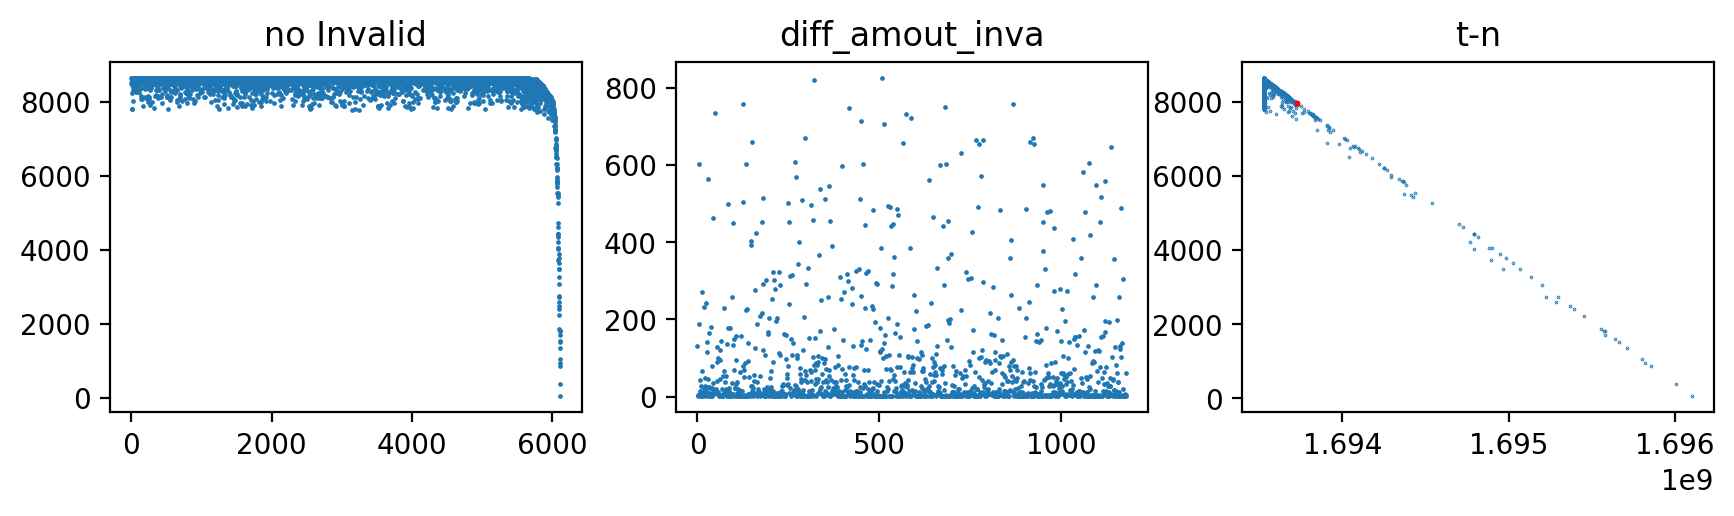

In [641]:
x = [x for x in range(0,no_error.shape[0])]
x1 =[x1 for x1 in range(0,no_error[no_error["diff_amout_inva"]!=0].shape[0])]
plt.figure(figsize=(14,5),dpi = 200)
plt.subplot(2, 4, 1)
plt.scatter(x,no_error["no Invalid"],s=0.5,)# 原图
plt.title("no Invalid")
plt.subplot(2, 4, 2)
plt.title("diff_amout_inva")
plt.scatter(x1,no_error["diff_amout_inva"][no_error["diff_amout_inva"]!=0],s=0.5)

plt.subplot(2, 4, 3)
plt.title("t-n")
plt.scatter(no_error["start_time"],no_error["data amount"],s=0.1)
plt.scatter(1693724700,7977,s=1,c="red")
plt.scatter(1693724700,7977,s=1,c="red")
plt.show()

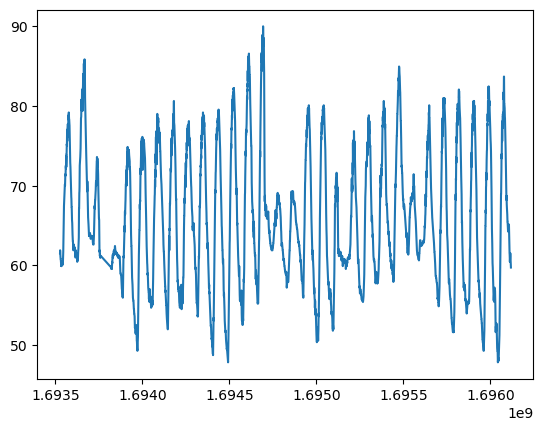

In [636]:
k = 148860
error_device = dic[k]
plt.plot(error_device["create_time"],error_device["tempf"])
plt.show()

In [658]:
print("大于0.065的设备数量:",no_error[no_error["up"]>0.065].shape[0])
ab = no_error[["up","down"]][(no_error["up"]>0.065)]
print(ab.describe())
no_error[no_error["down"]==no_error["down"].min()]
print("设备情况:\n")
no_error[no_error["up"]>0.0891]

大于0.065的设备数量: 30
              up       down
count  30.000000  30.000000
mean    0.082559  -0.081273
std     0.019387   0.019083
min     0.065520  -0.168660
25%     0.074000  -0.086300
50%     0.080000  -0.080000
75%     0.089100  -0.070000
max     0.169740  -0.065200
设备情况:



,device_id,start_time,end_time,time_point,data amount,no null,no Invalid,features,invaid_1_col,invaid_2_col,...,time_miss_afdel,up,down,mean,error,from_start_toEnd,diff_amout_inva,inva_ideal_rate,inva_amount_rate,work_rate
4026,146337,1693526400,1696118100,8640.0,8581,8581,8581,['tempf' 'create_time'],[],[],...,"[{1.0: (1693563600, 1693564200)}, {1.0: (16935...",0.09000,-0.08600,0.00000,no error,8640.0,0,0.993171,1.000000,0.993171
4951,141038,1693526400,1696118100,8640.0,8626,8626,8318,['tempf' 'create_time'],[],['tempf'],...,"[{1.0: (1693833900, 1693834500)}, {12.0: (1693...",0.09840,-0.08720,0.00320,no error,8640.0,308,0.962731,0.964294,0.962731
5460,149448,1693526400,1696118100,8640.0,8640,8640,8619,['tempf' 'create_time'],[],['tempf'],...,"[{4.0: (1694570100, 1694571600)}, {16.0: (1694...",0.16974,-0.16866,0.00144,no error,8640.0,21,0.997569,0.997569,0.997569
5541,143398,1693526400,1696118100,8640.0,8623,8623,8623,['tempf' 'create_time'],[],[],...,"[{1.0: (1694178900, 1694179500)}, {3.0: (16942...",0.10000,-0.09840,0.00080,no error,8640.0,0,0.998032,1.000000,0.998032
7105,143593,1693526400,1696118100,8640.0,8561,8561,8561,['tempf' 'create_time'],[],[],...,"[{1.0: (1693532400, 1693533000)}, {1.0: (16935...",0.09000,-0.08600,0.00000,no error,8640.0,0,0.990856,1.000000,0.990856
7265,143509,1693526400,1696118100,8640.0,8485,8485,8484,['tempf' 'create_time'],[],['tempf'],...,"[{1.0: (1693534200, 1693534800)}, {1.0: (16935...",0.09600,-0.09600,0.00000,no error,8640.0,1,0.981944,0.999882,0.981944
7459,140121,1693543200,1696118100,8584.0,8581,8581,8580,['tempf' 'create_time'],[],['tempf'],...,"[{1.0: (1693673700, 1693674300)}, {1.0: (16940...",0.09351,-0.09297,0.00000,no error,8584.0,1,0.999534,0.999883,0.999534
7493,141574,1693545600,1696118100,8576.0,8576,8576,8576,['tempf' 'create_time'],[],[],...,[],0.09260,-0.09140,0.00020,no error,8576.0,0,1.000000,1.000000,1.000000


## 最值分析

In [3]:
key = 143398 

In [4]:
dan = outlier_copy(dic[key])
#print(dan)
#der(dan.iloc[:,1],dan.iloc[:,0])
threshold_up = 0.089100 # 3分位数
threshold_down =-0.070000
n1 =0
n = 200
d2 = der(dan["create_time"].iloc[n1:n],dan["tempf"].iloc[n1:n])
0#print(d2)
plt.figure(figsize=(10,5),dpi = 200)
t_od = (dan["create_time"]-dan["create_time"].min())/300
t_od = t_od.iloc[n1:n]
dan["create_time"] = (dan["create_time"]-dan["create_time"].min())/300
abnormal_t_d2,abnormal_d2 =[],[]
for i in range(len(d2)):
    if d2[i] != None:
        if ((d2[i]>threshold_up)|(d2[i]<threshold_down)):
            abnormal_t_d2.append(t_od.iloc[i+2])
            abnormal_d2.append(dan["tempf"][dan["create_time"]==t_od.iloc[i+2]])    
y_od = dan["tempf"].iloc[n1:n]
plt.plot(t_od,y_od,linewidth = 0.5)# 原图
plt.scatter(abnormal_t_d2,abnormal_d2,s=1,c="red")
plt.xlabel("5*min")
plt.ylabel("tempf")
#plt.plot(t_od.iloc[1:],d1)
plt.show()
print()

NameError: name 'outlier_copy' is not defined

## 全局threshold情况分析

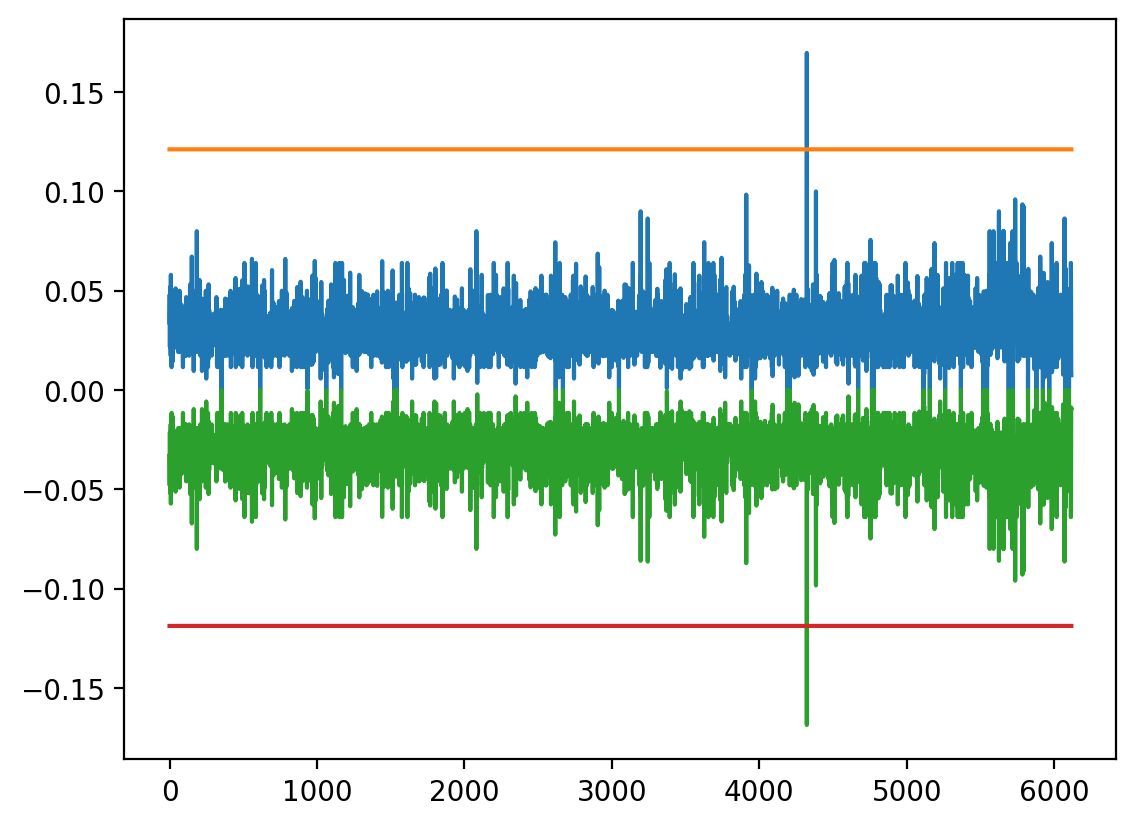

In [643]:
x = [x for x in range(0,no_error.shape[0])]
uniq =[]
for i in range(no_error.shape[0]):
    uniq.append(threshold_up)
#print(x) 
uniq2 =[]
for i in range(no_error.shape[0]):
    uniq2.append(threshold_down)
plt.figure(dpi = 200)
plt.plot(x,no_error["up"])# 原图
plt.plot(x,uniq)
plt.plot(x,no_error["down"])
plt.plot(x,uniq2)


#plt.plot(t_od.iloc[2:],d2) 
#plt.plot(t_od.iloc[1:],d1)
plt.show()

conclusion : samples are not enough,so that the result is not ideal  
strategy : we need to find a great deal of data samples to analyse

# 6.孤立森林找出离群的的up，down

In [42]:
no_error = no_error.sample(frac=1)  # 把数据打乱
no_error = no_error[["up"]]
try:
        model = IsolationForest(n_estimators=100,
                      max_samples="auto",
                      contamination=float(0.1), # 假设一个5%的异常比例
                      max_features=1)
        model.fit(no_error)
except:
        print("模型的值全为无效值")
else:
        scores = model.decision_function(no_error)
        anomaly = model.predict(no_error)
no_error["scores"] = scores
no_error["anomaly"] = anomaly
print(no_error)


          up    scores  anomaly
1531  0.0458 -0.001109       -1
574   0.0266  0.096631        1
2072  0.0320  0.159551        1
2454  0.0356  0.073552        1
3857  0.0320  0.159551        1
...      ...       ...      ...
4344  0.0367  0.081118        1
3954  0.0277  0.098721        1
5030  0.0276  0.100238        1
2749  0.0189  0.032804        1
4159  0.0372  0.092777        1

[4699 rows x 3 columns]


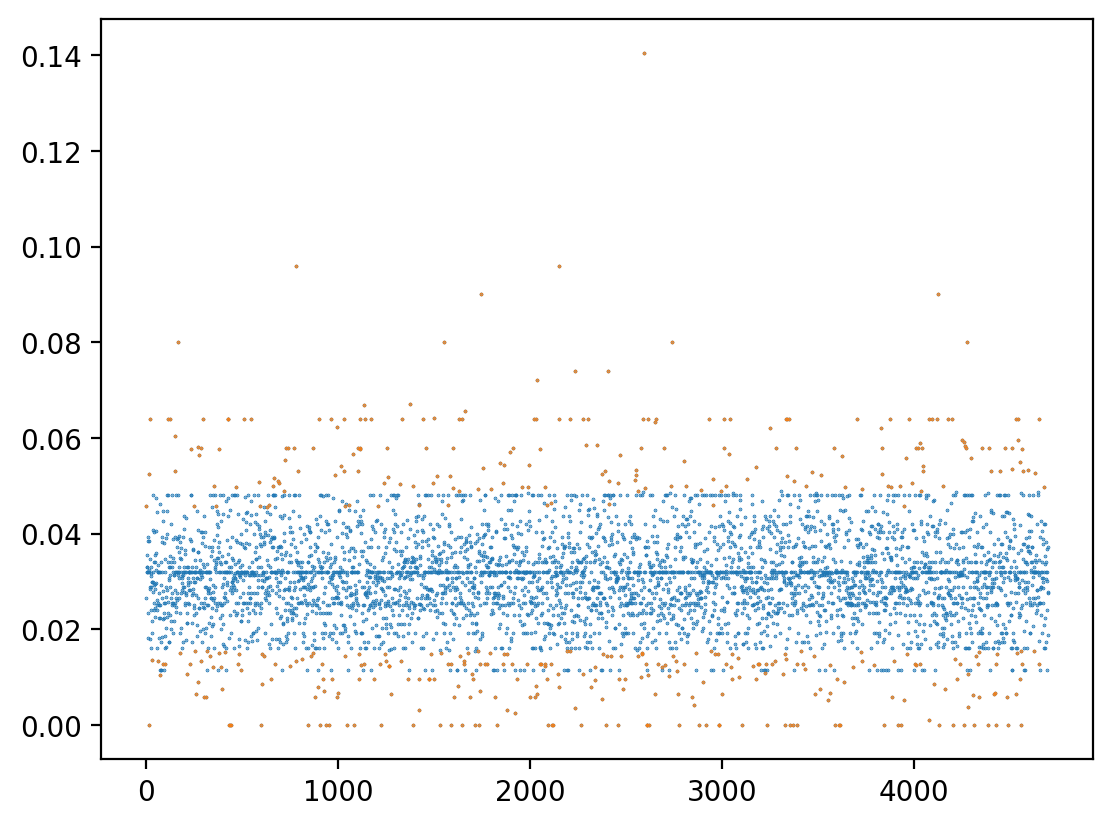

In [43]:
x = [x for x in range(0,no_error.shape[0])]
no_error["x"] = x
dr = no_error[no_error["anomaly"]==-1]

plt.figure(dpi = 200)
plt.xlim = (0,0.15,0.01)
plt.ylim = (-0.14,0,0.01)

plt.scatter(x,no_error["up"],s=0.1)# 原图
plt.scatter(dr["x"],dr["up"],s=0.1)
plt.show()

# 7.验证异常

In [ ]:
abnormal_t_d2,abnormal_d2 =[],[]
for i in range(len(d2)):
    if ((d2[i]>up)|(d2[i]<down)):
        abnormal_t_d2.append(t_od.iloc[i+2])
        abnormal_d2.append(df["tempf"][df["create_time"]==t_od.iloc[i+2]])